In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import sklearn

from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid


def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)) / (np.abs(np.array(y_true)) + np.abs(np.array(y_pred)))) * 200

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)) / np.abs(np.array(y_true))) * 100

In [14]:
def plot_profile(y_pred, y_true):
    
    for i in range(0,len(y_true)):
        y_pred.transpose()[i].plot(c = 'r')
        y_true.transpose().iloc[:,i].plot(c = 'g', legend = True, ylim = (0, y_true.transpose().iloc[:,i].max()*3))
        plt.show()
        plt.clf()
        print('sMAPE:', symmetric_mean_absolute_percentage_error(y_true.transpose()[y_true.index[i]],y_pred.transpose()[i]))
        print('MAPE:', mean_absolute_percentage_error(y_true.transpose()[y_true.index[i]],y_pred.transpose()[i]))


In [17]:
def process_data(task = 'regression', fillna = True, verbose = 0):

    if verbose > 0:
        print('Loading files... ', '\n')

    # Select seasonal load: 'Loads.xlsx' (April), 'Loads summer.xlsx' (June) or 'Loads winter.xlsx' (June) 
    load_file = 'Loads.xlsx'

    files = ['5 Boiler - Buildings.xlsx',                                          # 0
             '5 Kaltwasserversorgungsanlagen - Buildings.xlsx',                    # 1
             '5 Heizung - Buildings.xlsx',                                         # 2
             '5 Kaelteanlagen - Buildings - filled median all.xlsx',               # 3
             
             '5 Lueftungsanlagen - Buildings - filled median all.xlsx',            # 4
             '5 Lueftungsanlagen - Buildings - filled median all share.xlsx',      # 5      

             '5 Rooms - Buildings2.xlsx',                                          # 6
             '5 Rooms - Buildings share2.xlsx']                                    # 7

    
    # Files are chosen depending on the pretictive task
    if task == 'regression':
        use_files = [0,1,2,3,4,6]
    else:
        use_files = [0,1,2,3,5,7]
    
    
    # Load files
    loads = pd.read_csv('Load Profiles.csv', index_col = 0)
    buildings = list(loads.columns)[0:-2]

    dataset = pd.DataFrame([])

    for file in use_files:
        temp = pd.read_excel(files[file], index_col = 0, converters={'Building': str})
        dataset = pd.concat([dataset,temp],axis = 1)

    Buildings = []
    for b in buildings:
        Buildings.append(round(float(b)*100))

    dataset = dataset.loc[Buildings,:]


    profiles = pd.read_excel(load_file, index_col = 0)
    profiles.index = Buildings
    
    # Undesired profiles can be deleted here by including the building names in the list
    delete_profiles = []
    profiles.drop(delete_profiles, inplace = True)
    dataset.drop(delete_profiles, inplace = True)
        
        

    # Organize data
    if verbose > 0:
        print('Processing data...','\n')

    fill_NaN_with_0 = list(dataset.drop(['Boiler - Age', 'Cold Water Supply - Age', 'Heating - Age', 'Cooling - Age', 'Ventilation - Age'],axis = 1).columns)
    dataset[fill_NaN_with_0] = dataset[fill_NaN_with_0].fillna(0)

    features = [['Boiler - Age','Boiler - Size','Boiler - Pump Power'],
                ['Cold Water Supply - Age','Cold Water Supply - Pump Power'],
                ['Heating - Age','Heating - Electrical Power Source','Heating - Non Electrical Power Source','Heating - Pump Power','Heating - Radiators'],
                ['Cooling - Age','Cooling - Power'],
                ['Ventilation - Age','Ventilation - Room - Outgoing - Power','Ventilation - Room - Circulating - Power','Ventilation - Room - Ingoing - Power','Ventilation - Wall - Outgoing - Power','Ventilation - Wall - Circulating - Power','Ventilation - Wall - Ingoing - Power','Ventilation - Central - Outgoing - Power','Ventilation - Central - Circulating - Power','Ventilation - Central - Ingoing - Power','Ventilation - Room - Outgoing - Volume Flow','Ventilation - Room - Circulating - Volume Flow','Ventilation - Room - Ingoing - Volume Flow','Ventilation - Wall - Outgoing - Volume Flow','Ventilation - Wall - Circulating - Volume Flow','Ventilation - Wall - Ingoing - Volume Flow','Ventilation - Central - Outgoing - Volume Flow','Ventilation - Central - Circulating - Volume Flow','Ventilation - Central - Ingoing - Volume Flow','Ventilation - Cooling Power','Ventilation - Heating Power','Ventilation - Heat Recovery Power'],
                ['Technical Equipment Room','Technical Equipment Room AU','Technical Equipment Room AW','Technical Equipment Room ET','Technical Equipment Room HA','Technical Equipment Room LA','Technical Equipment Room TG', 'Biological Laboratory', 'Changing Room','Chemical Laboratory', 'Conference', 'DV-Room', 'Dining Room','Electrical Laboratory', 'Electronic Laboratory', 'Elevator', 'Garage','General Laboratory', 'Isotopic Laboratory', 'Kitchen', 'Lecture Room','Library', 'Living Room', 'Office', 'Office Kitchen', 'Other','Physical Laboratory', 'Reception', 'Refrigerated Room', 'Rest Area','Server Room', 'Shower', 'Storage', 'Technological Laboratory','Traffic Area', 'WC', 'Workshop']]

    
    if use_files[4] == 5:
        features[4] = ['Ventilation - Age','Ventilation - Room - Outgoing - Power','Ventilation - Room - Circulating - Power','Ventilation - Room - Ingoing - Power','Ventilation - Wall - Outgoing - Power','Ventilation - Wall - Circulating - Power','Ventilation - Wall - Ingoing - Power','Ventilation - Central - Outgoing - Power','Ventilation - Central - Circulating - Power','Ventilation - Central - Ingoing - Power','Ventilation - Total Power','Ventilation - Room - Outgoing - Volume Flow','Ventilation - Room - Circulating - Volume Flow','Ventilation - Room - Ingoing - Volume Flow','Ventilation - Wall - Outgoing - Volume Flow','Ventilation - Wall - Circulating - Volume Flow','Ventilation - Wall - Ingoing - Volume Flow','Ventilation - Central - Outgoing - Volume Flow','Ventilation - Central - Circulating - Volume Flow','Ventilation - Central - Ingoing - Volume Flow','Ventilation - Total Volume Flow','Ventilation - Cooling Power','Ventilation - Heating Power','Ventilation - Heat Recovery Power']

    if use_files[5] == 7:
        features[5] = ['Technical Equipment Room','Technical Equipment Room AU','Technical Equipment Room AW','Technical Equipment Room ET','Technical Equipment Room HA','Technical Equipment Room LA','Technical Equipment Room TG', 'Biological Laboratory', 'Changing Room','Chemical Laboratory', 'Conference', 'DV-Room', 'Dining Room','Electrical Laboratory', 'Electronic Laboratory', 'Elevator', 'Garage','General Laboratory', 'Isotopic Laboratory', 'Kitchen', 'Lecture Room','Library', 'Living Room', 'Office', 'Office Kitchen', 'Other','Physical Laboratory', 'Reception', 'Refrigerated Room', 'Rest Area','Server Room', 'Shower', 'Storage', 'Technological Laboratory','Traffic Area', 'WC', 'Workshop','Total area']

    if fillna == True:
        for cols in features[:-1]:
            median_age = dataset[cols[0]].dropna().median()

            for i, row in dataset.iterrows():

                if np.isnan(row[cols[0]]) and row[cols[1:]].sum() == 0:
                    dataset.loc[i,cols[0]] = -2
                elif np.isnan(row[cols[0]]) and row[cols[1:]].sum() != 0:
                    dataset.loc[i,cols[0]] = median_age

        if dataset.isnull().sum().sum() != 0:
            for i in range(10):
                    print('Warning: NaN')

                    
                    
    # Columns to be scaled depending on the selected files
    columns_to_scale = []
    
    columns_to_scale = columns_to_scale + features[0]
    columns_to_scale = columns_to_scale + features[1]
    columns_to_scale = columns_to_scale + features[2]
    columns_to_scale = columns_to_scale + features[3]
    
    if use_files[4] == 4:
        columns_to_scale = columns_to_scale + features[4]
    else:
        columns_to_scale = columns_to_scale + ['Ventilation - Age','Ventilation - Total Power','Ventilation - Total Volume Flow','Ventilation - Cooling Power','Ventilation - Heating Power','Ventilation - Heat Recovery Power']

    if use_files[5] == 6:
        columns_to_scale = columns_to_scale + features[5]
    else:
        columns_to_scale = columns_to_scale + ['Total area']

        
        
    return (dataset, profiles, columns_to_scale)


# - - - - - - - - - - - - - - - - - - - - - - REGRESSION - - - - - - - - - - - - - - - - - - - - - - - - - 

In [27]:
seed = 42
test_size = 0.2
cv = 6

# Select Algorithms (Careful with Ensemble if any of the other algorithms is not activated)
lasso_pred = True
svr_pred = True
rf_pred = True
lgbm_pred = True
mlp_pred = True
ens_pred = True 

# Show regression results if True
regression_results = False

In [28]:
cv_MAPES = []
cv_sMAPES = []
test_MAPES = []
test_sMAPES = []
sd_MAPES = []
sd_sMAPES = []
cv_reg_predictions = []
test_reg_predictions = []

In [29]:
# SCALE DATA
dataset, profiles, columns_to_scale = process_data(task = 'regression', fillna = True)
x_train, x_test, y_train, y_test = train_test_split(dataset,profiles,test_size = test_size, random_state = seed)

robust_scaler = RobustScaler(with_centering=False, quantile_range=(0.0, 98.0), copy=True)
x_train_sc = x_train.copy()
x_train_sc[columns_to_scale] = robust_scaler.fit_transform(x_train[columns_to_scale])
x_test_sc = x_test.copy()
x_test_sc[columns_to_scale] = robust_scaler.transform(x_test[columns_to_scale])

x_train_log = np.log(x_train_sc+1) # X log
x_test_log = np.log(x_test_sc+1)

y_train_log = np.log(y_train + 1) # Y log
y_test_log = np.log(y_test + 1)

## LASSO

In [30]:
if lasso_pred == True:
    
    plot_lasso = False
    print('\nFitting Lasso...')

    y_pred = pd.DataFrame([])
    cv_pred = pd.DataFrame([])

    # Train and predict lasso for every hour
    for i in range(24):

        lasso = Lasso(alpha = 0.1, max_iter=1000000, fit_intercept = True, normalize = False, precompute = True, random_state = 0)
        cv_pred[i] = np.exp(cross_val_predict(lasso, x_train_sc, y_train_log[i], cv = cv))-1
        
        lasso.fit(x_train_sc, y_train_log[i])
        y_pred[i] = np.exp(lasso.predict(x_test_sc))-1
        
    cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)  
    test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)
    cv_MAPE = mean_absolute_percentage_error(y_train,cv_pred)  
    test_MAPE = mean_absolute_percentage_error(y_test,y_pred)
       
    cv_sMAPES.append(cv_sMAPE)
    test_sMAPES.append(test_sMAPE)
    cv_MAPES.append(cv_MAPE)
    test_MAPES.append(test_MAPE)
    cv_reg_predictions.append(cv_pred)
    test_reg_predictions.append(y_pred)
    
    if plot_lasso == True:
        plot_profile(y_pred, y_test)
        


Fitting Lasso...



## SUPPORT VECTOR MACHINE 

In [32]:
if svr_pred == True:
    
    plot_svr = False    
    print('\nFitting Support Vector Machine...')

    y_pred = pd.DataFrame([])
    cv_pred = pd.DataFrame([])

    best_params = {}
    best_sMAPE = np.inf
    
    grid_svr = {'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                'C': [10000, 1000, 100, 10, 1, 0.1, 0.01],
                'epsilon' : [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]}
    
    space_svr = ParameterGrid(grid_svr)
    
    # Grid search
    for params in space_svr:
        
        for i in range(24):

            svr = SVR(kernel = 'rbf', **params)
            cv_pred[i] = np.exp(cross_val_predict(svr, x_train_log, y_train_log[i], cv = cv))-1
        
        cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)   
            
        if cv_sMAPE < best_sMAPE:
            best_sMAPE = cv_sMAPE
            best_params = params
    
    # Train and predict SVR for every hour
    for i in range(24):

        svr = SVR(kernel = 'rbf', **best_params)
        cv_pred[i] = np.exp(cross_val_predict(svr, x_train_log, y_train_log[i], cv = cv))-1
        
        svr.fit(x_train_log, y_train_log[i])
        y_pred[i] = np.exp(svr.predict(x_test_log))-1
        
    cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)  
    test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)
    cv_MAPE = mean_absolute_percentage_error(y_train,cv_pred)  
    test_MAPE = mean_absolute_percentage_error(y_test,y_pred)
    
    cv_sMAPES.append(cv_sMAPE)
    test_sMAPES.append(test_sMAPE)
    cv_MAPES.append(cv_MAPE)
    test_MAPES.append(test_MAPE)
    cv_reg_predictions.append(cv_pred)
    test_reg_predictions.append(y_pred)
    
    if plot_svr == True:
        plot_profile(y_pred, y_test)


Fitting Support Vector Machine...


## RANDOM FOREST

In [35]:
if rf_pred == True:
   
    plot_rf = False 
    
    print('\nFitting Random Forest...')

    y_pred = pd.DataFrame([])
    cv_pred = pd.DataFrame([])

    best_params = {}
    best_sMAPE = np.inf
    
    grid_rf = {'n_estimators': np.arange(20, 350, 15),
                'max_depth':[5, 7, 10, 12, 15],
                'max_features' : ['sqrt'],
                'min_samples_leaf':[2, 3, 4, 5],
                'criterion': ['mse']}
    
    space_rf = ParameterGrid(grid_rf)
    
    # Grid search 
    for params in space_rf:
        
        for i in range(24):

            rf = RandomForestRegressor(**params, random_state = 0)
            cv_pred[i] = np.exp(cross_val_predict(rf, x_train_sc, y_train_log[i], cv = cv))-1
            
        cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)      
        
        if cv_sMAPE < best_sMAPE:
            best_sMAPE = cv_sMAPE
            best_params = params

    # Train and predict RF for every hour
    for i in range(24):

        rf = RandomForestRegressor(**best_params, random_state = 0)
        cv_pred[i] = np.exp(cross_val_predict(rf, x_train_sc, y_train_log[i], cv = cv))-1
        
        rf.fit(x_train_sc, y_train_log[i])
        y_pred[i] = np.exp(rf.predict(x_test_sc))-1
        
    cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)  
    test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)
    cv_MAPE = mean_absolute_percentage_error(y_train,cv_pred)  
    test_MAPE = mean_absolute_percentage_error(y_test,y_pred)
    
    cv_sMAPES.append(cv_sMAPE)
    test_sMAPES.append(test_sMAPE)
    cv_MAPES.append(cv_MAPE)
    test_MAPES.append(test_MAPE)
    cv_reg_predictions.append(cv_pred)
    test_reg_predictions.append(y_pred)
    
    if plot_rf == True:
        plot_profile(y_pred, y_test)


Fitting Random Forest...


## LIGHTGBM

In [36]:
if lgbm_pred == True:
    
    plot_lgbm = False
    print('\nFitting LightGBM...')

    y_pred = pd.DataFrame([])
    cv_pred = pd.DataFrame([])

    best_params = {}
    best_sMAPE = np.inf
    
    grid_lgbm = {'learning_rate':[0.02, 0.05, 0.2],
                'n_estimators' : np.arange(10, 300, 15),
                'num_leaves' : [3, 4, 5, 6, 7],
                'max_depth' : [2, 3, 4, 5],
                'colsample_bytree' : [0.3, 0.4, 0.5],
                'objective' : ['regression'],
                'reg_alpha' : [0, 1],
                'reg_lambda' : [0, 1]}

    space_lgbm = ParameterGrid(grid_lgbm)
    
    # Grid search
    for params in space_lgbm:
        
        for i in range(24):

            lgbm = LGBMRegressor(boosting_type = 'gbdt', random_state = 0, **params)
            cv_pred[i] = cross_val_predict(lgbm, x_train_sc, y_train[i], cv = cv)
            
        cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)       
        
        if cv_sMAPE < best_sMAPE:
            best_sMAPE = cv_sMAPE
            best_params = params
    
    # Train and predict LGBM for every hour
    for i in range(24):

        lgbm = LGBMRegressor(boosting_type = 'gbdt', random_state = 0, **best_params)
        cv_pred[i] = cross_val_predict(lgbm, x_train_sc, y_train[i], cv = cv)
        
        lgbm.fit(x_train_sc, y_train[i])
        y_pred[i] = lgbm.predict(x_test_sc)
        
    cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)  
    test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)
    cv_MAPE = mean_absolute_percentage_error(y_train,cv_pred)  
    test_MAPE = mean_absolute_percentage_error(y_test,y_pred)
    
    cv_sMAPES.append(cv_sMAPE)
    test_sMAPES.append(test_sMAPE)
    cv_MAPES.append(cv_MAPE)
    test_MAPES.append(test_MAPE)
    cv_reg_predictions.append(cv_pred)
    test_reg_predictions.append(y_pred)
    
    if plot_lgbm == True:
        plot_profile(y_pred, y_test)



Fitting LightGBM...


## ARTIFICIAL NEURAL NETWORK

In [37]:
if mlp_pred == True:
    
    plot_mlp = False    
    print('\nFitting Artificial Neural Network...')

    y_pred = pd.DataFrame([])
    cv_pred = pd.DataFrame([])

    best_params = {}
    best_sMAPE = np.inf
    
# Grid search (VERY SLOW and bad results for such a small dataset)
#    grid_mlp = {'solver': ['lbfgs'],
#                'hidden_layer_sizes': [[64, 64, 64], [128, 128, 128], [128, 64, 64, 64, 64]],
#                'alpha': [0.001, 0.002]}
#    
#    space_mlp = ParameterGrid(grid_mlp)
#    
#    for params in space_mlp:
#        
#
#        for i in range(24):
#
#            mlp = MLPRegressor(activation = 'relu', max_iter = 1000, early_stopping = True, random_state = 0, **params)
#            cv_pred[i] = np.exp(cross_val_predict(mlp, x_train_sc, y_train_log[i], cv = cv))-1
#        
#
#        if cv_sMAPE < best_sMAPE:
#            best_sMAPE = cv_sMAPE
#            best_params = params
#

    # Train and predict ANN for every hour
    best_params = {'solver': 'lbfgs', 'hidden_layer_sizes': [128, 64, 64, 64, 64, 64], 'alpha': 0.002}

    for i in range(24):

        mlp = MLPRegressor(activation = 'relu', max_iter = 1000, early_stopping = True, random_state = 0, **best_params)
        cv_pred[i] = np.exp(cross_val_predict(mlp, x_train_sc, y_train_log[i], cv = cv, n_jobs = -1))-1
        
        mlp.fit(x_train_sc, y_train_log[i])
        y_pred[i] = np.exp(mlp.predict(x_test_sc))-1

        
    cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)  
    test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)
    cv_MAPE = mean_absolute_percentage_error(y_train,cv_pred)  
    test_MAPE = mean_absolute_percentage_error(y_test,y_pred)
        
    cv_sMAPES.append(cv_sMAPE)
    test_sMAPES.append(test_sMAPE)
    cv_MAPES.append(cv_MAPE)
    test_MAPES.append(test_MAPE)
    cv_reg_predictions.append(cv_pred)
    test_reg_predictions.append(y_pred)
    
    if plot_mlp == True:
        plot_profile(y_pred, y_test)



Fitting Artificial Neural Network...


## ENSEMBLE

In [39]:
if ens_pred == True:
    
    plot_ens = False
    print('\n','Fitting Ensemble...')

    y_pred = pd.DataFrame([])
    cv_pred = pd.DataFrame([])

    best_params = {}
    best_sMAPE = np.inf
    
    grid_ens = {'n_estimators': np.arange(20, 350, 15),
                'max_depth':[5, 7, 10, 12, 15],
                'max_features' : ['sqrt'],
                'min_samples_leaf':[2, 3, 4, 5],
                'criterion': ['mse']}
    
    space_ens = ParameterGrid(grid_ens)
    
    x_train_sc.reset_index(drop=True, inplace = True)    
    x_test_sc.reset_index(drop=True, inplace = True)  
    
    # Grid search
    for params in space_ens:

        for i in range(0): 
                                           
            x_train_ens = pd.concat([x_train_sc, cv_reg_predictions[0][i], cv_reg_predictions[1][i], cv_reg_predictions[2][i], 
                                     cv_reg_predictions[3][i]], axis = 1) #Include ANN with cv_reg_predictions[4][i]  
            
            ens = RandomForestRegressor(**params, random_state = 0)
            cv_pred[i] = np.exp(cross_val_predict(ens, x_train_ens, y_train_log[i], cv = cv))-1
        
        if cv_sMAPE < best_sMAPE:
            best_sMAPE = cv_sMAPE
            best_params = params

    # Train and predict ensemble for every hour
    for i in range(24):
        
        x_train_ens = pd.concat([x_train_sc, cv_reg_predictions[0][i], cv_reg_predictions[1][i], cv_reg_predictions[2][i], 
                                 cv_reg_predictions[3][i]], axis = 1) #Include ANN with cv_reg_predictions[4][i]
        x_test_ens = pd.concat([x_test_sc, test_reg_predictions[0][i], test_reg_predictions[1][i], test_reg_predictions[2][i],
                                test_reg_predictions[3][i]], axis = 1) #Include ANN with test_reg_predictions[4][i] 

        ens = RandomForestRegressor(**best_params, random_state = 0)
        cv_pred[i] = np.exp(cross_val_predict(ens, x_train_ens, y_train_log[i], cv = cv))-1
        
        ens.fit(x_train_ens, y_train_log[i])
        y_pred[i] = np.exp(ens.predict(x_test_ens))-1

        
    cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)  
    test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)
    cv_MAPE = mean_absolute_percentage_error(y_train,cv_pred)  
    test_MAPE = mean_absolute_percentage_error(y_test,y_pred)
    
    cv_sMAPES.append(cv_sMAPE)
    test_sMAPES.append(test_sMAPE)
    cv_MAPES.append(cv_MAPE)
    test_MAPES.append(test_MAPE)
    cv_reg_predictions.append(cv_pred)
    test_reg_predictions.append(y_pred)
    
  
    if plot_ens == True:
        plot_profile(y_pred, y_test)

    cv_regression = cv_pred
    test_regression = y_pred
    
else:
    cv_regression = cv_reg_predictions[cv_sMAPES.index(max(cv_sMAPES))]
    test_regression = test_reg_predictions[cv_sMAPES.index(max(cv_sMAPES))]



 Fitting Ensemble...


# Regression Results


sMAPE
CV sMAPE:       [108.12289693855774, 78.78177994994722, 75.72816589870958, 120.99584112973308, 88.84659424282064, 72.6881499443494]
Test sMAPE:     [93.06343582728375, 75.78538760265464, 61.463845062538205, 114.4591503283723, 81.30707607405853, 58.59612834199059]
Test sMAPE std: [56.157993309390875, 50.49046625073226, 33.30887365377074, 63.46369310911793, 46.85796765707239, 29.901161090501752]

MAPE
CV MAPE:        [2398.8831783397522, 572.8151402276725, 743.2964032175771, 4413.691895270266, 1.938224537768359e+66, 585.7092416123439]
Test MAPE:      [490.4715370191356, 212.2797267081612, 106.9899296247602, 721.1259766250206, 559.7425389933649, 85.78328945618657]
Test MAPE std:  [1000.0398980673501, 448.36930419075975, 211.47694147550857, 1815.571340293231, 1972.8585192448224, 150.830741951273]


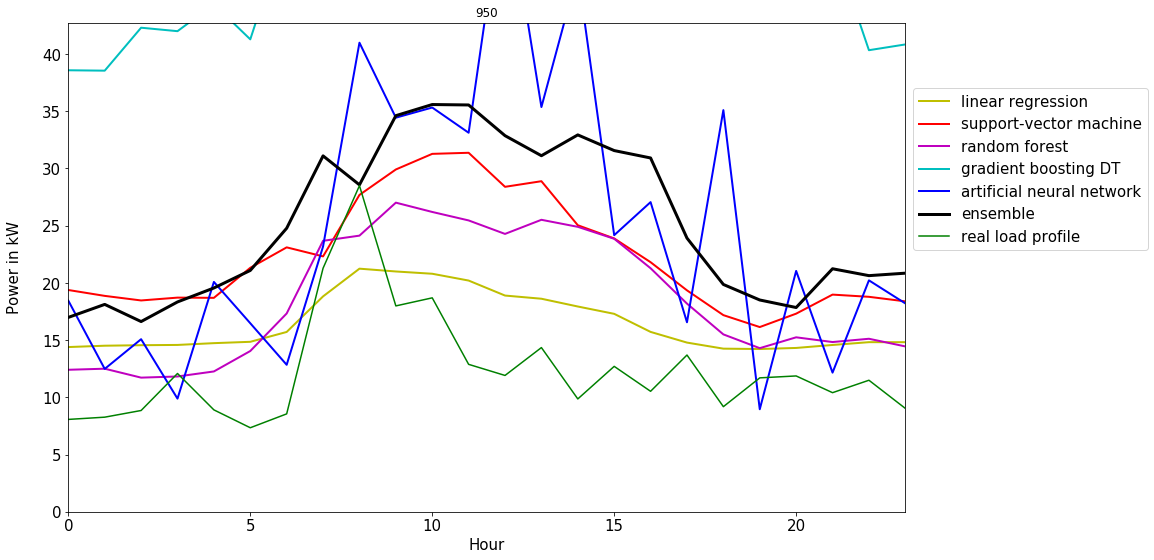

<Figure size 432x288 with 0 Axes>

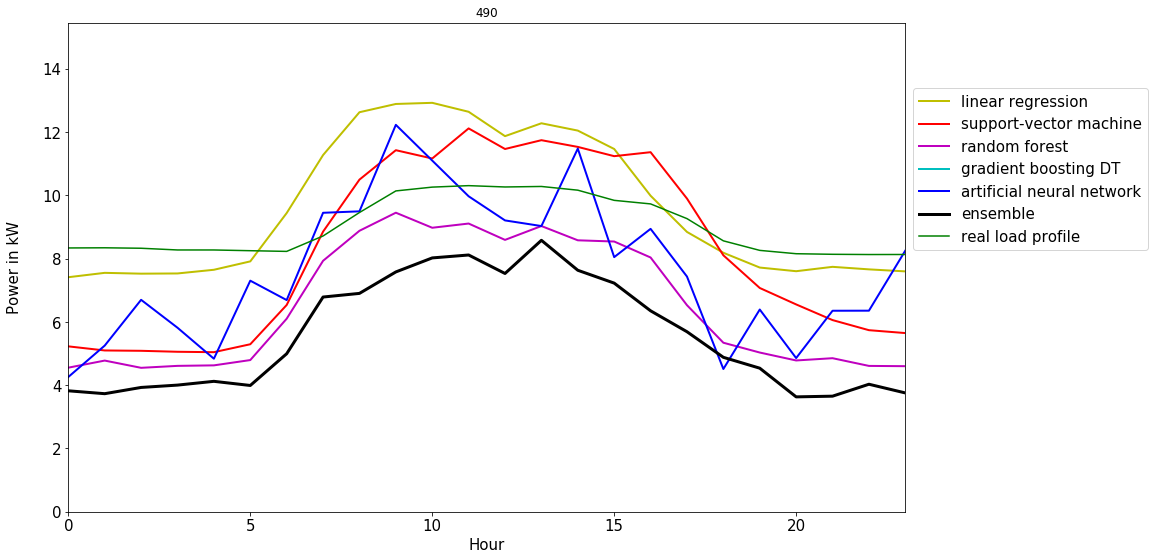

<Figure size 432x288 with 0 Axes>

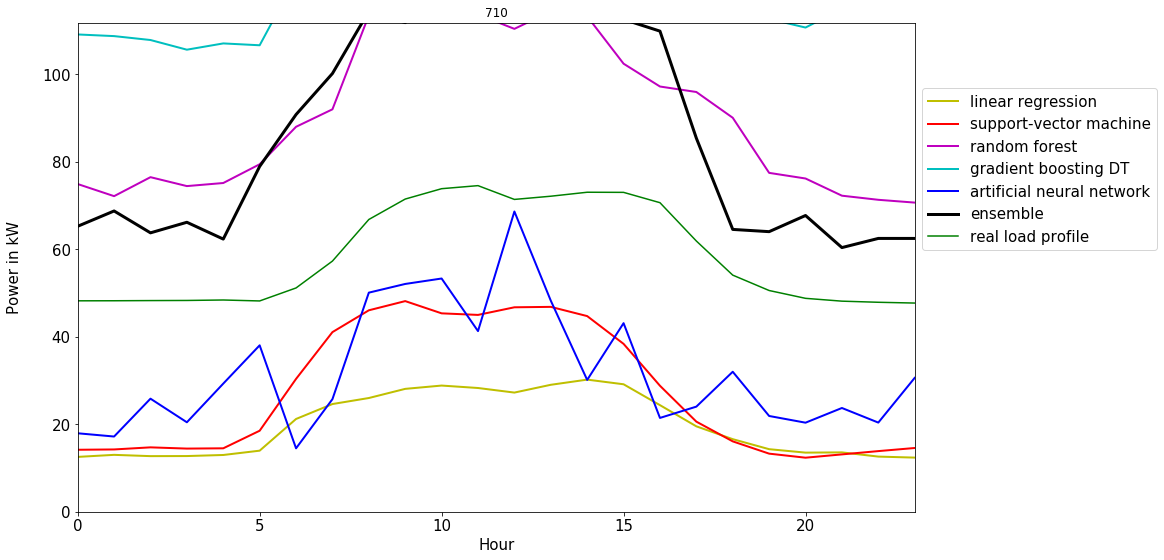

<Figure size 432x288 with 0 Axes>

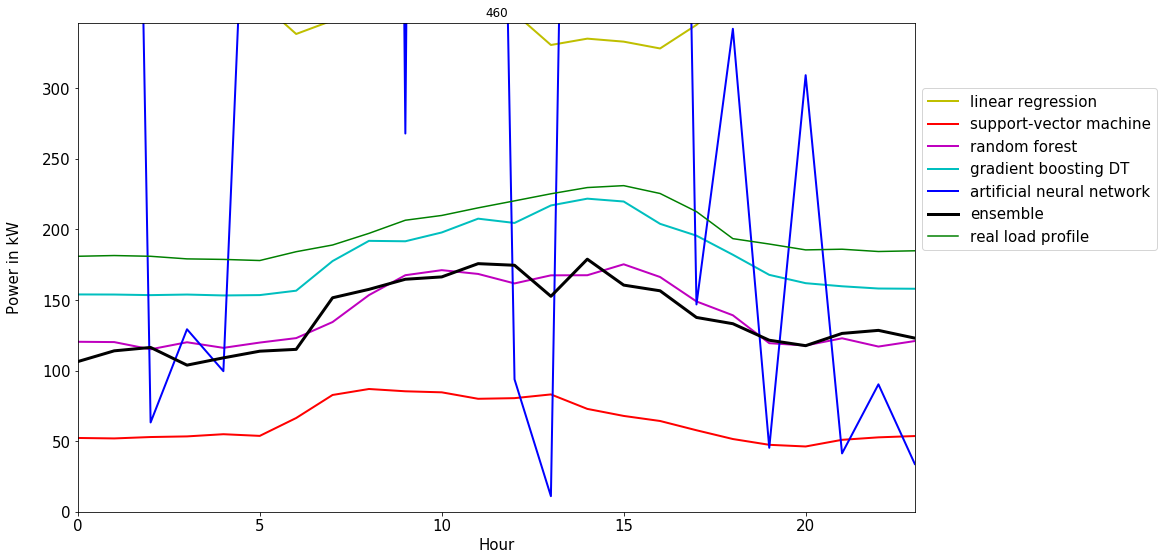

<Figure size 432x288 with 0 Axes>

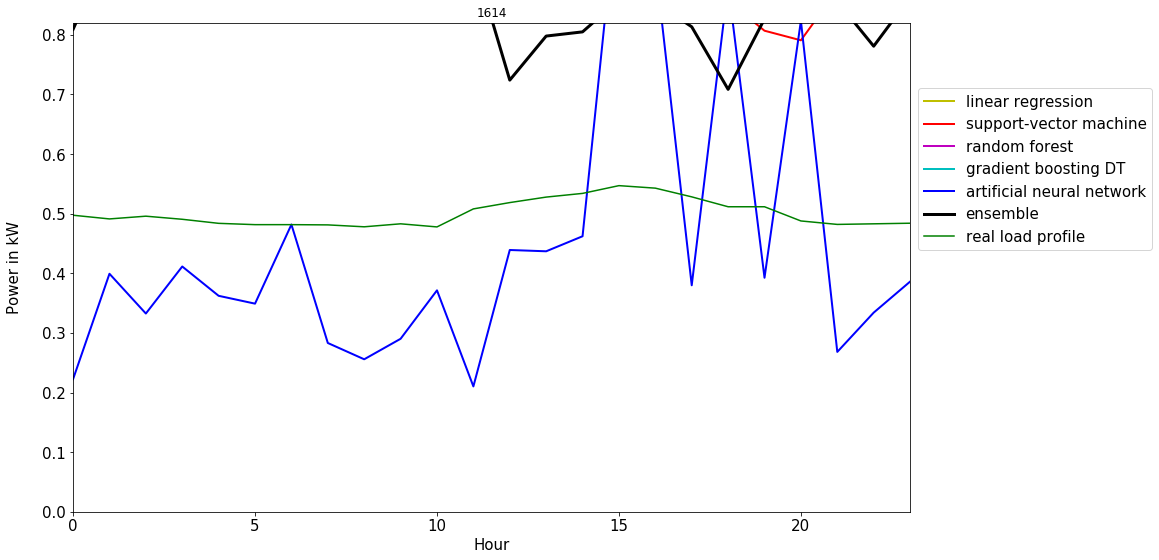

<Figure size 432x288 with 0 Axes>

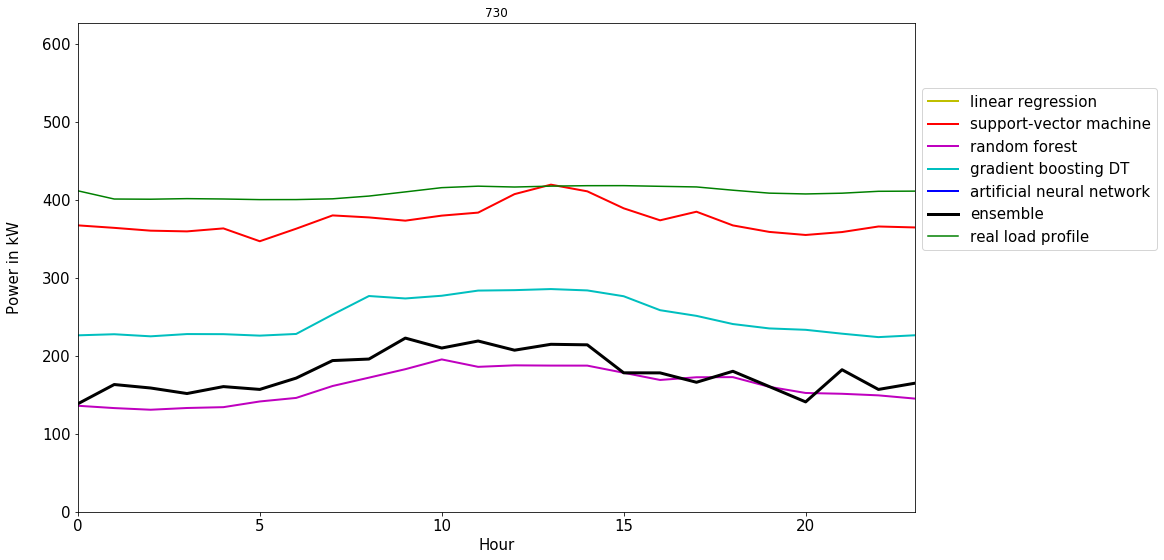

<Figure size 432x288 with 0 Axes>

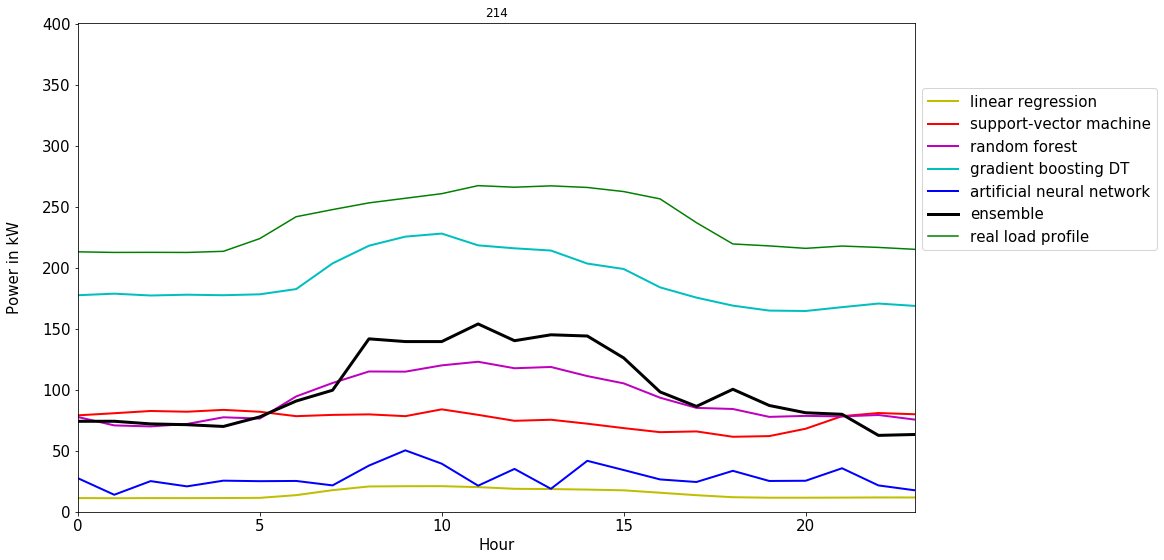

<Figure size 432x288 with 0 Axes>

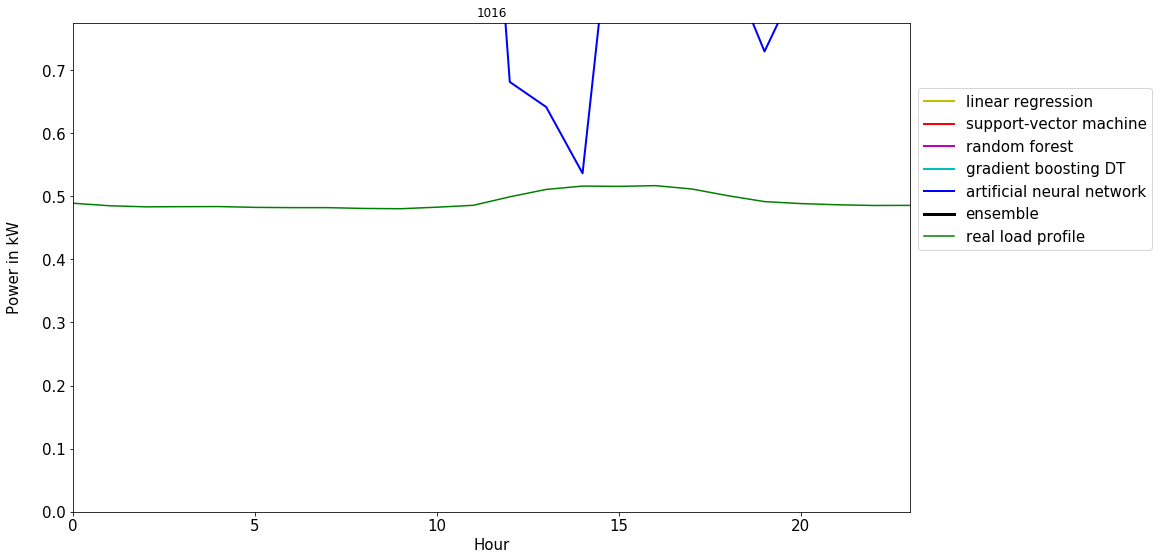

<Figure size 432x288 with 0 Axes>

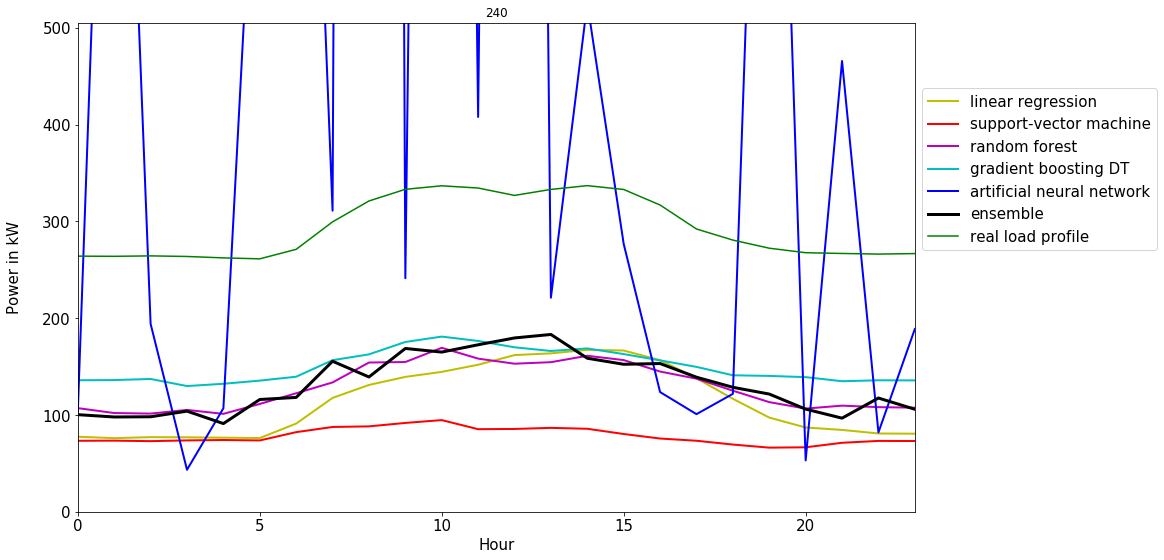

<Figure size 432x288 with 0 Axes>

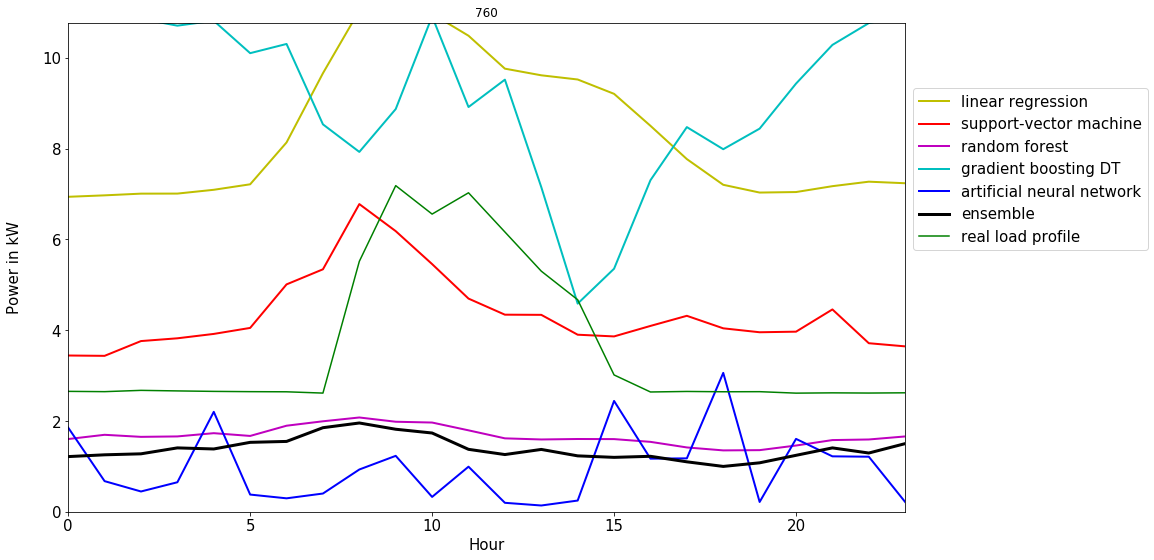

<Figure size 432x288 with 0 Axes>

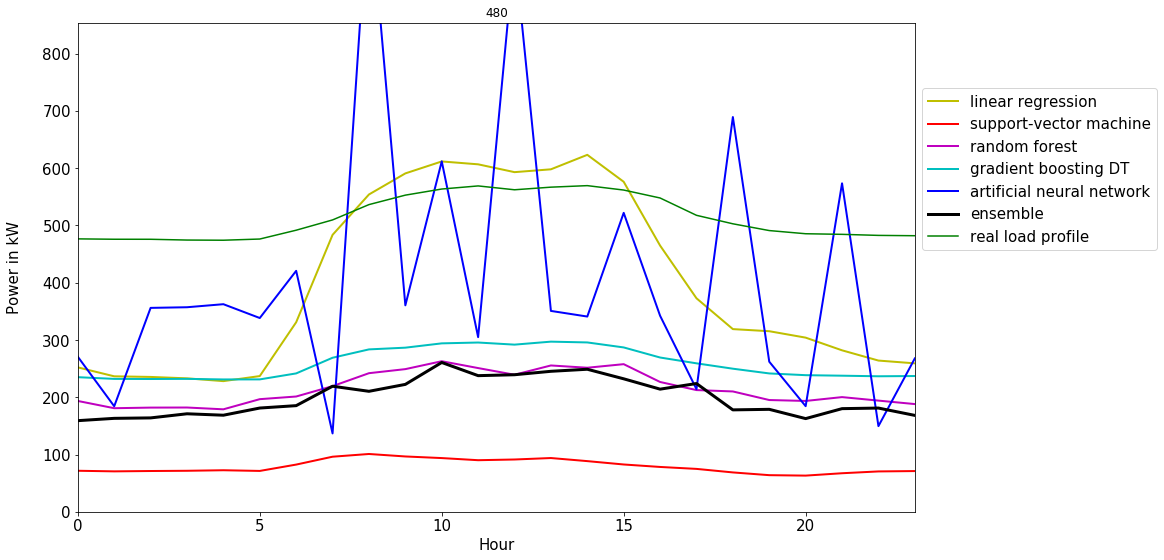

<Figure size 432x288 with 0 Axes>

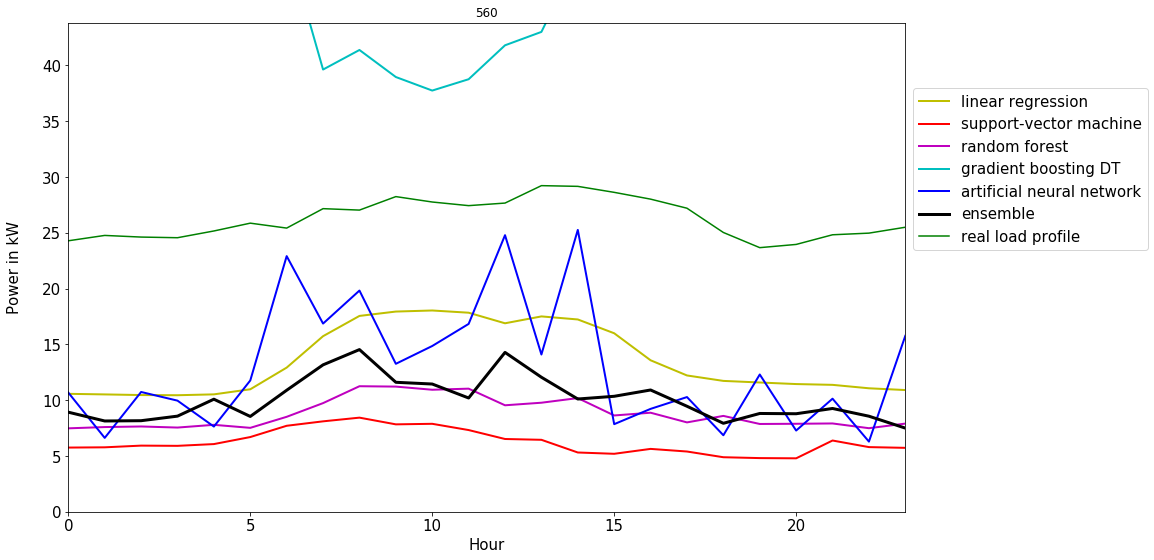

<Figure size 432x288 with 0 Axes>

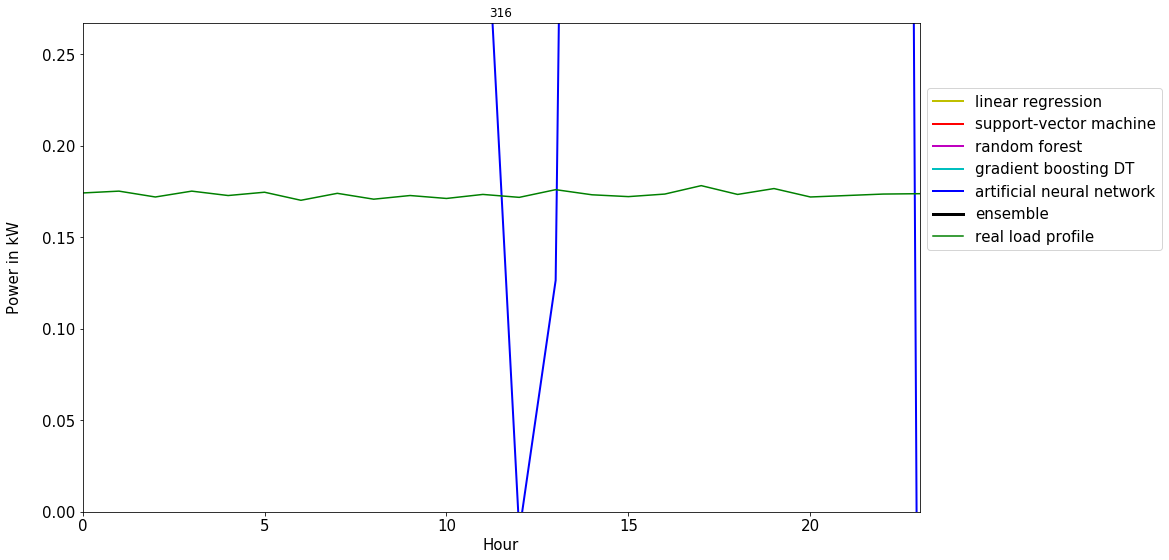

<Figure size 432x288 with 0 Axes>

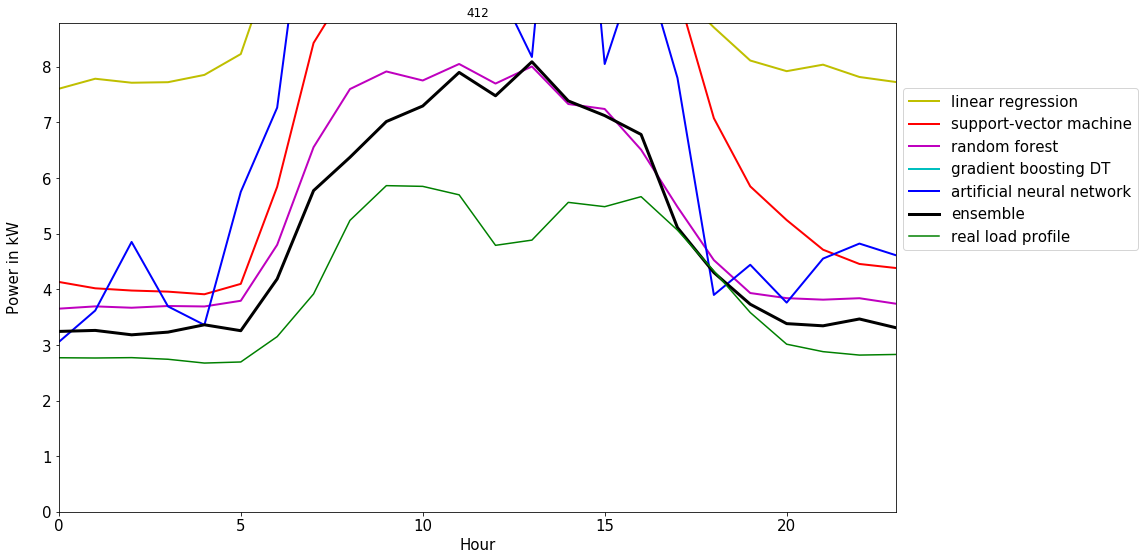

<Figure size 432x288 with 0 Axes>

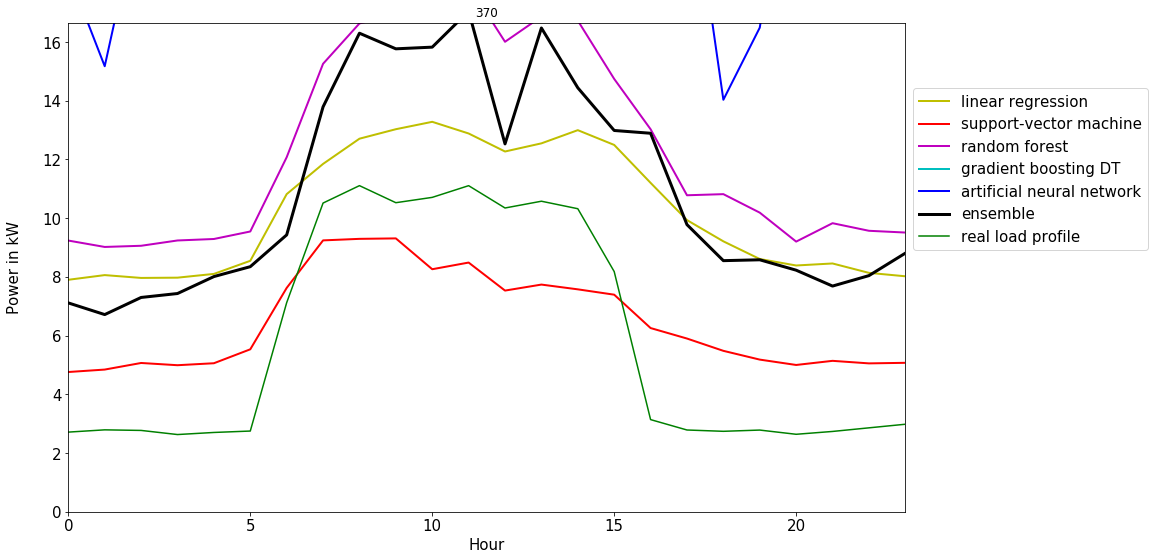

<Figure size 432x288 with 0 Axes>

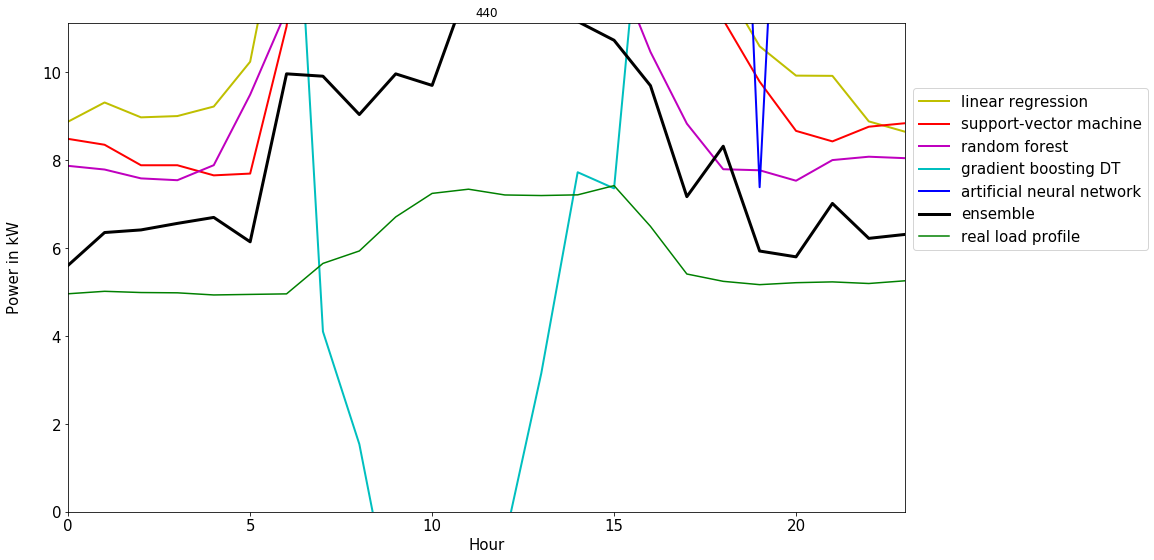

<Figure size 432x288 with 0 Axes>

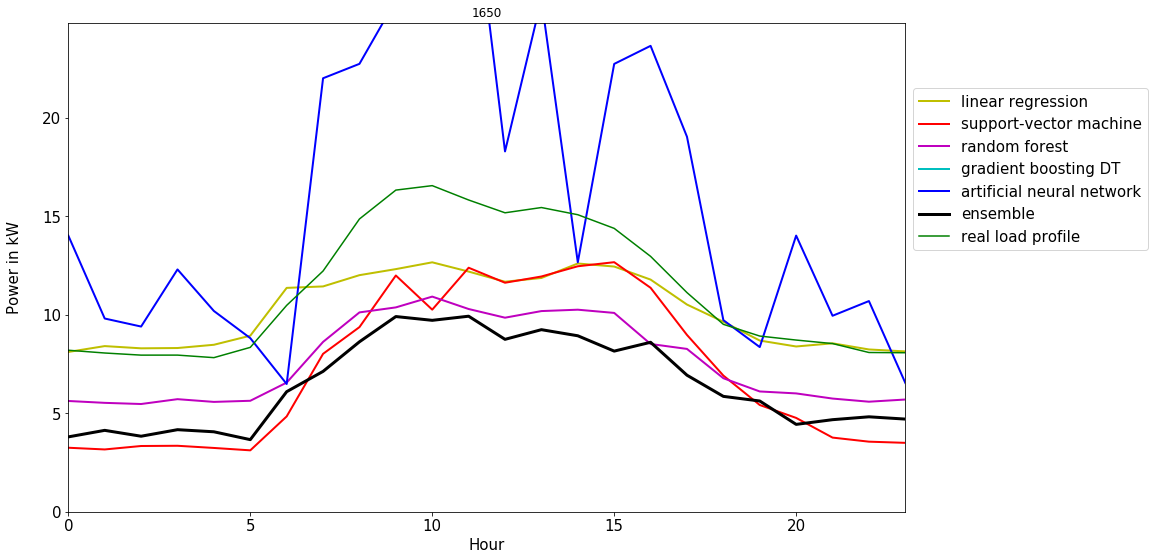

<Figure size 432x288 with 0 Axes>

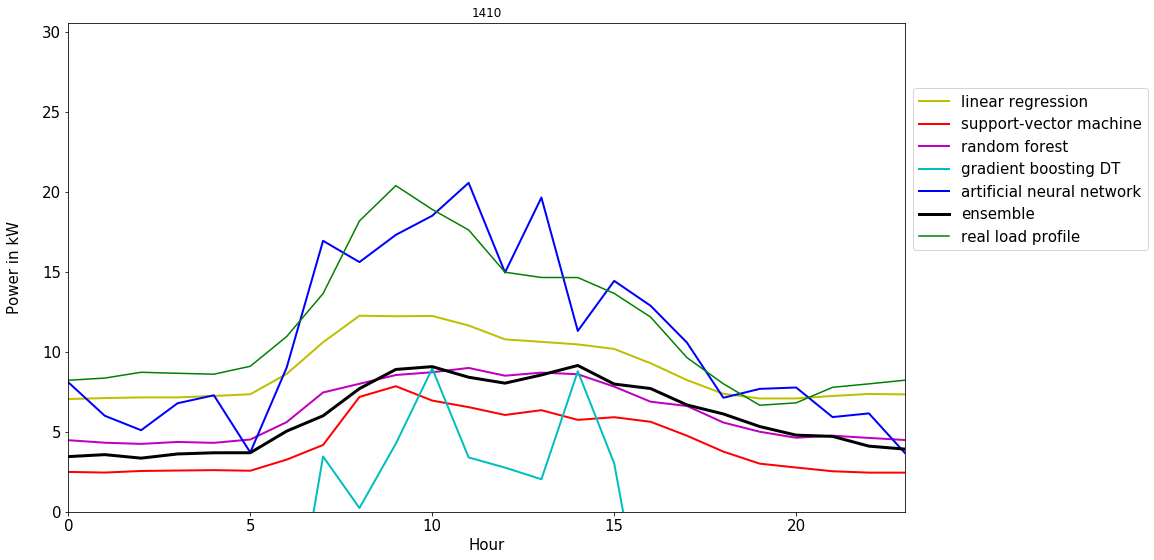

<Figure size 432x288 with 0 Axes>

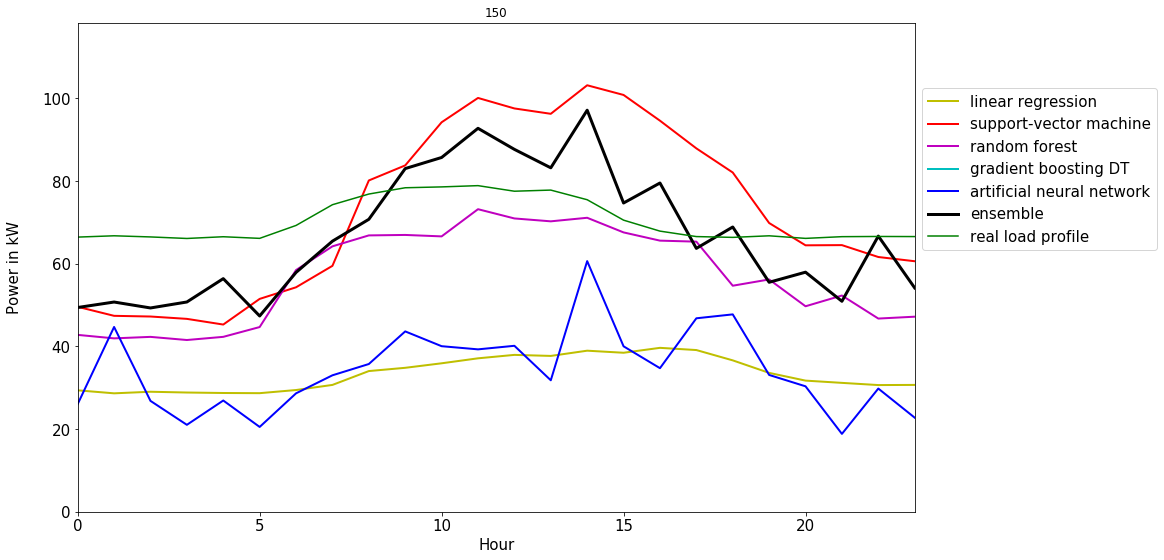

<Figure size 432x288 with 0 Axes>

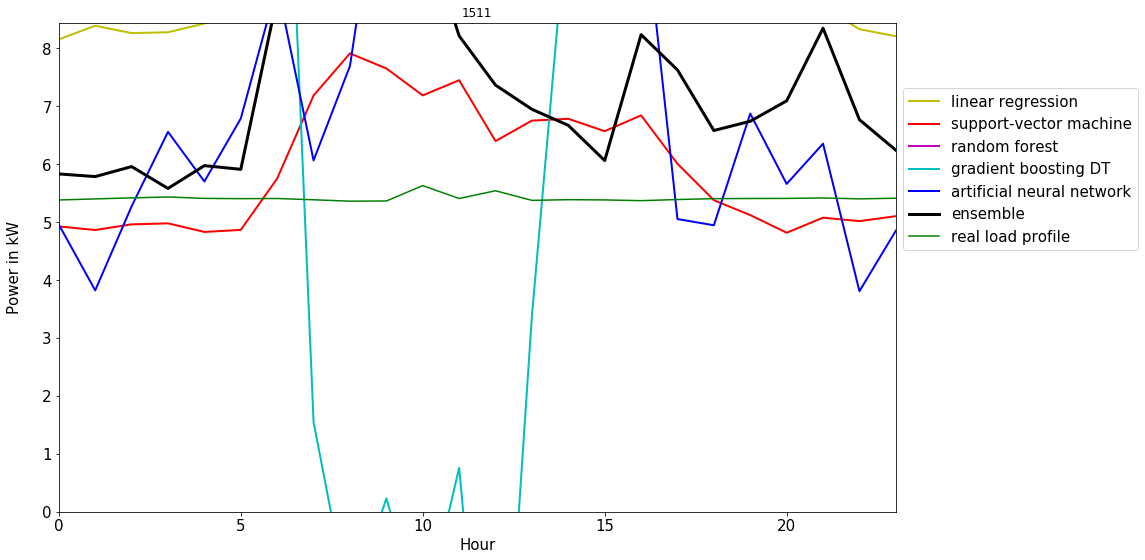

<Figure size 432x288 with 0 Axes>

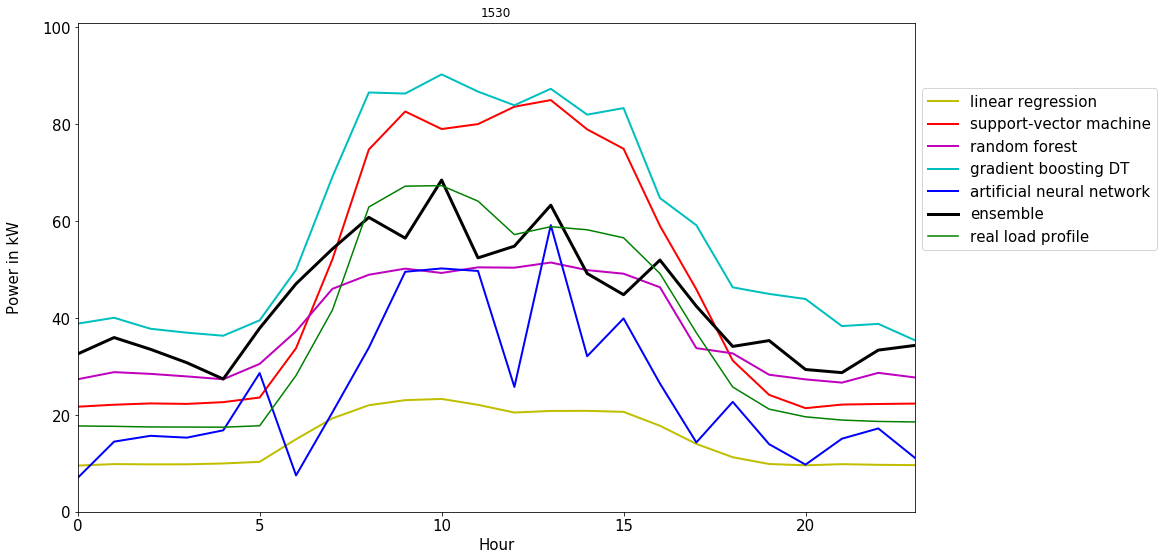

<Figure size 432x288 with 0 Axes>

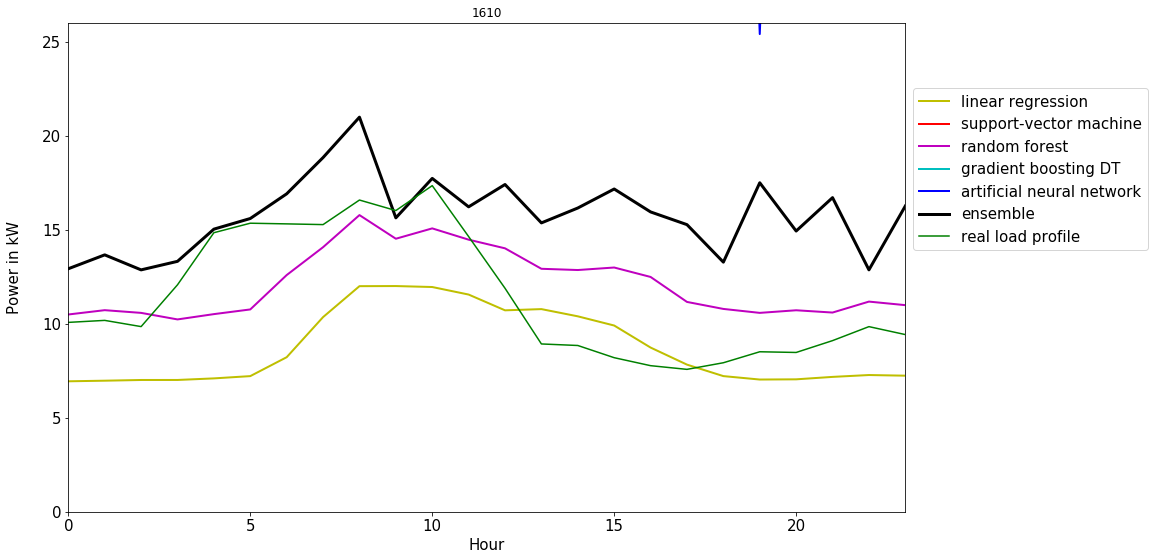

<Figure size 432x288 with 0 Axes>

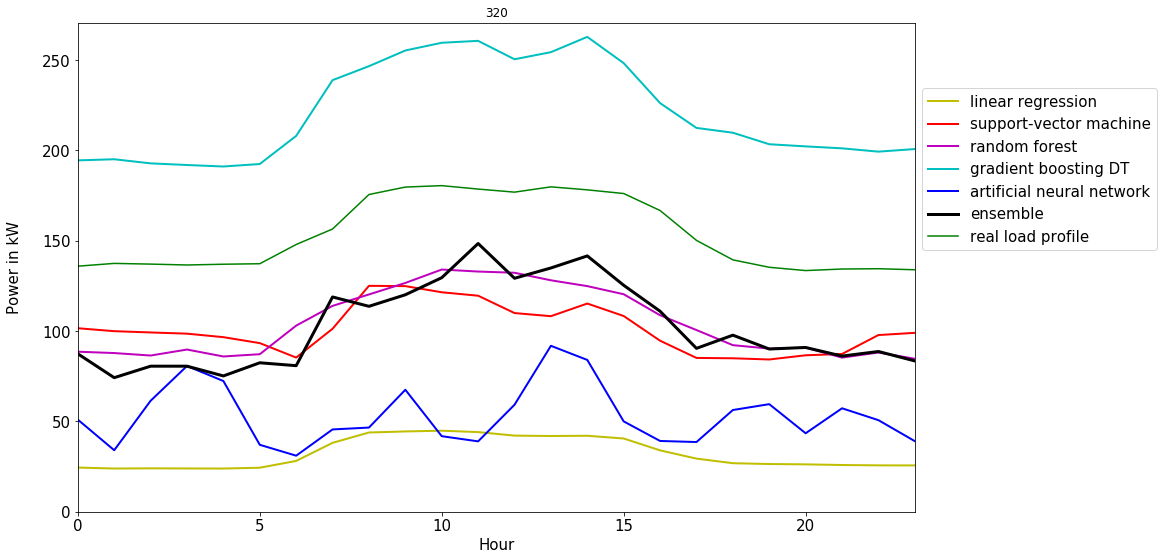

<Figure size 432x288 with 0 Axes>

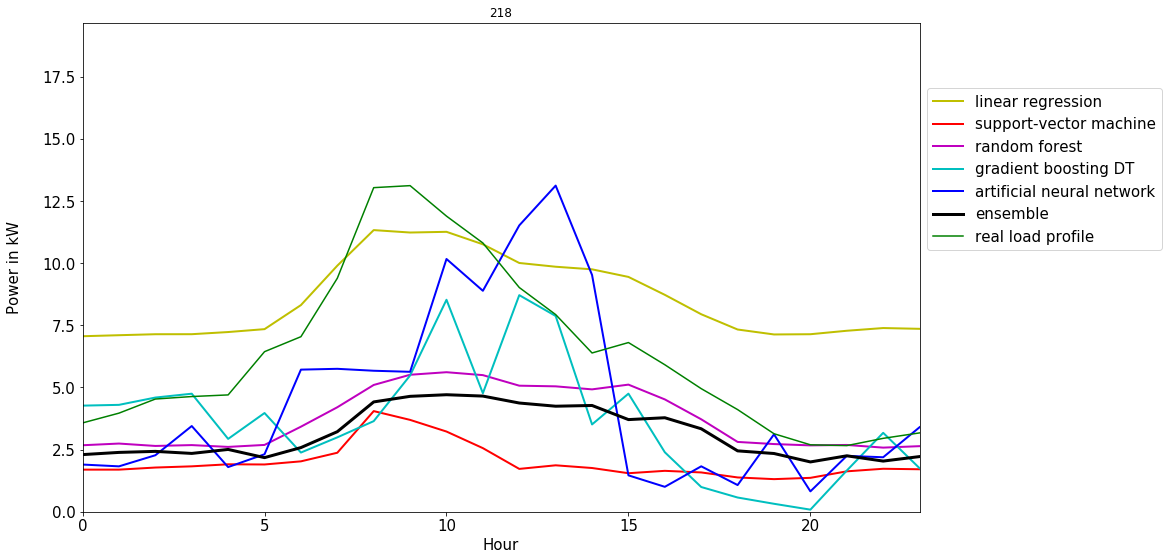

<Figure size 432x288 with 0 Axes>

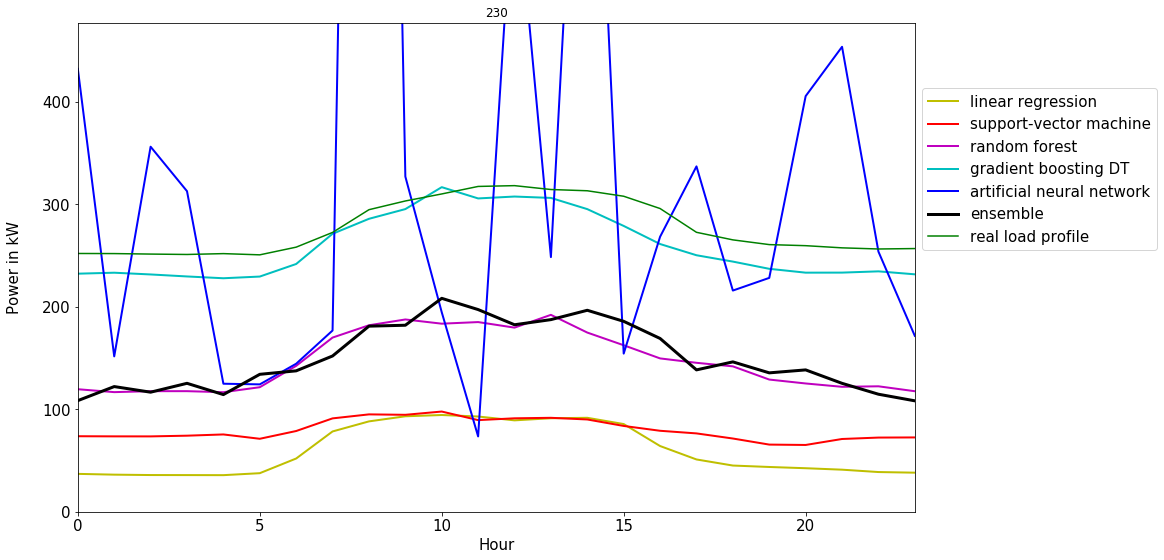

<Figure size 432x288 with 0 Axes>

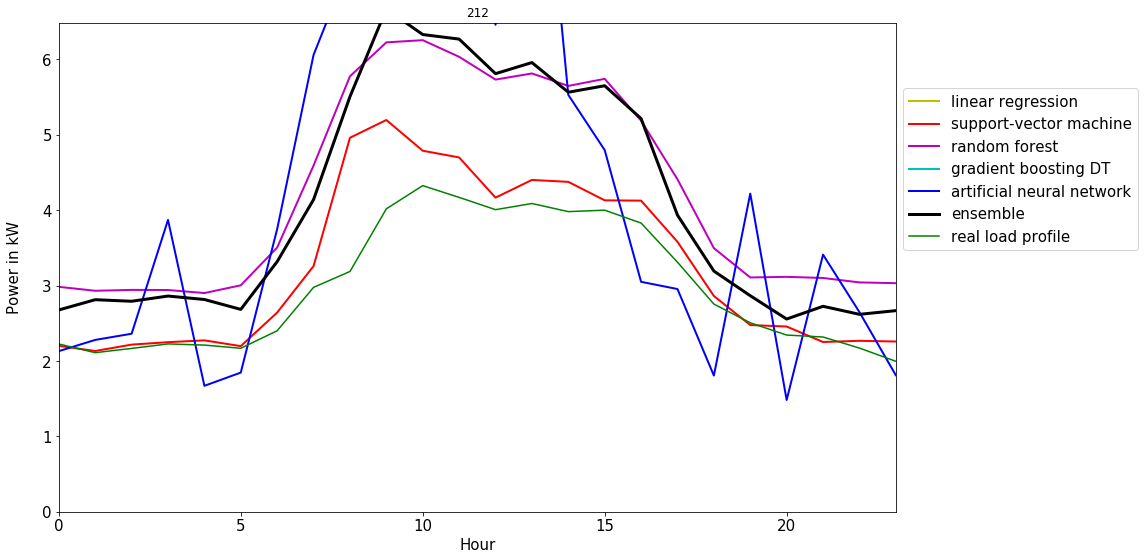

<Figure size 432x288 with 0 Axes>

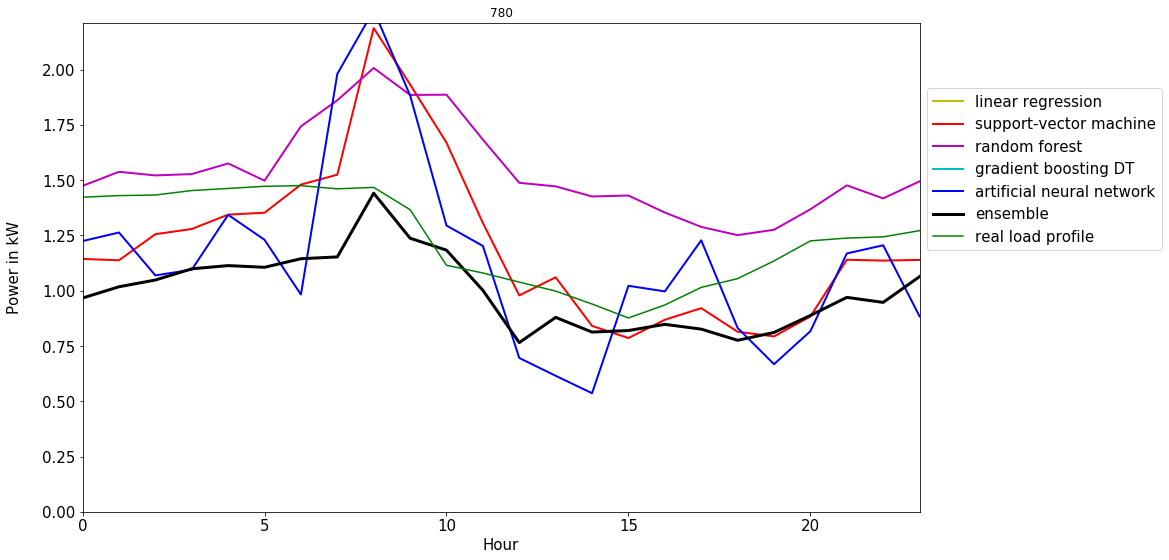

<Figure size 432x288 with 0 Axes>

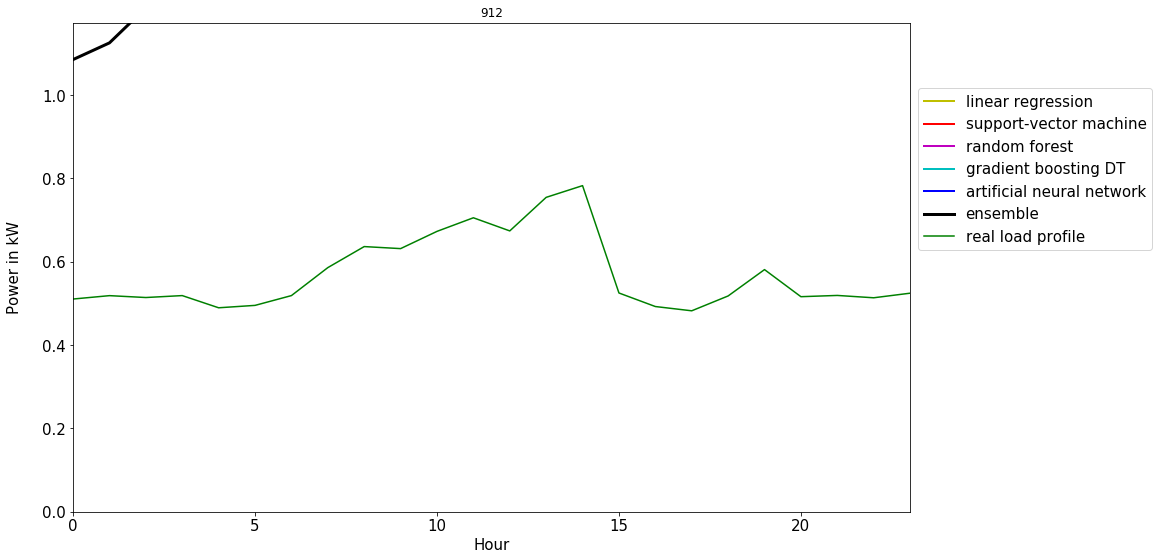

<Figure size 432x288 with 0 Axes>

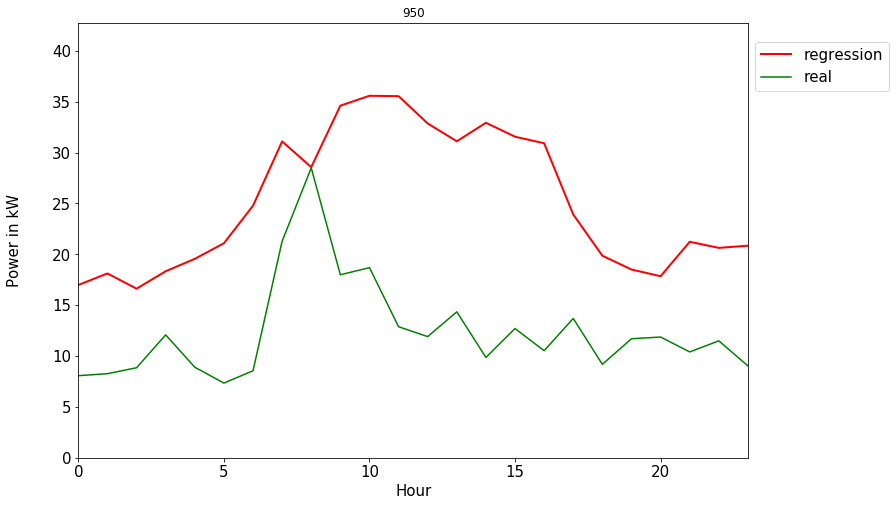

sMAPE: 58.59612834199061
MAPE: 114.69766851059833


<Figure size 432x288 with 0 Axes>

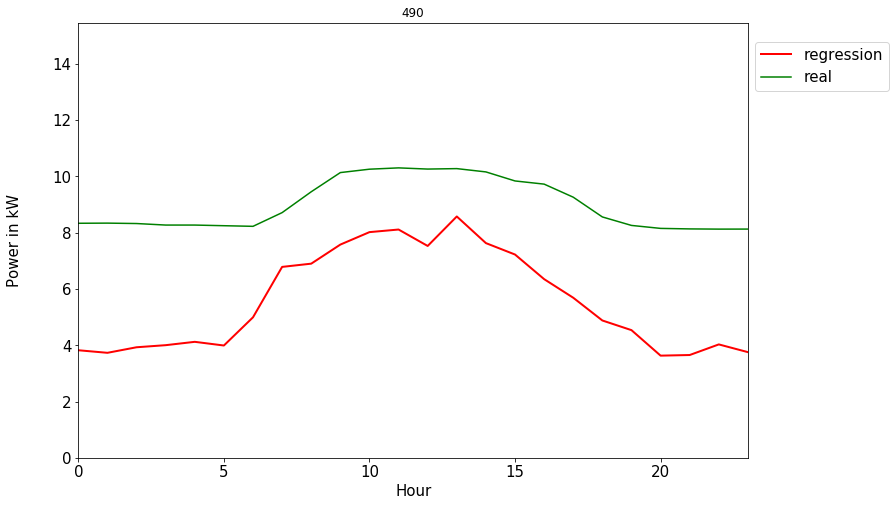

sMAPE: 58.59612834199061
MAPE: 39.29975503126819


<Figure size 432x288 with 0 Axes>

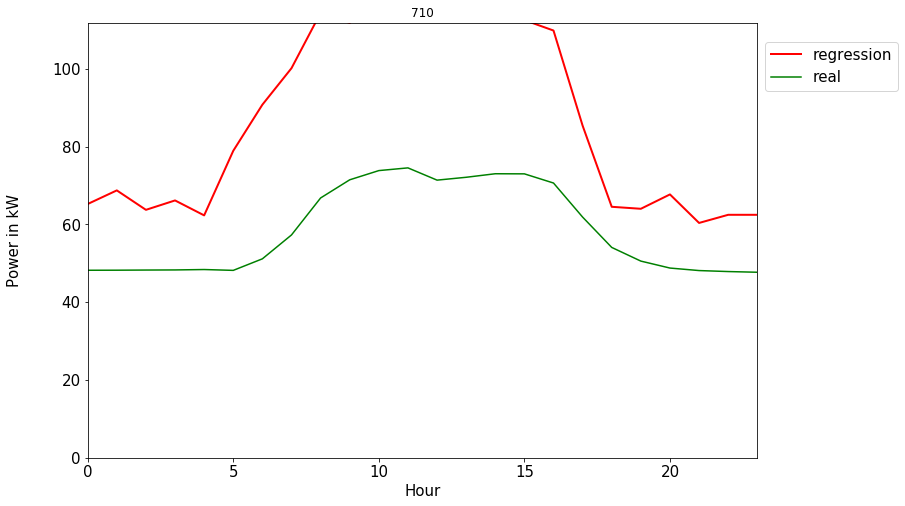

sMAPE: 58.59612834199061
MAPE: 49.40351899923529


<Figure size 432x288 with 0 Axes>

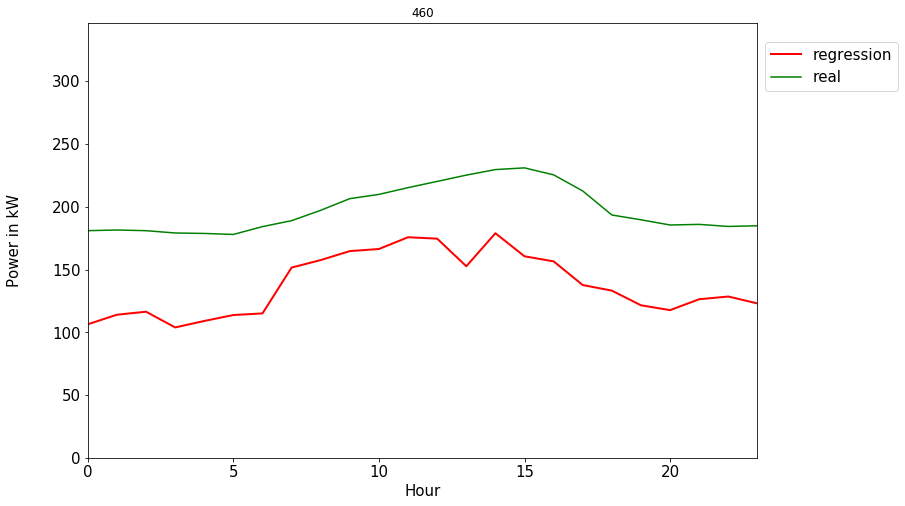

sMAPE: 58.59612834199061
MAPE: 30.7819398993041


<Figure size 432x288 with 0 Axes>

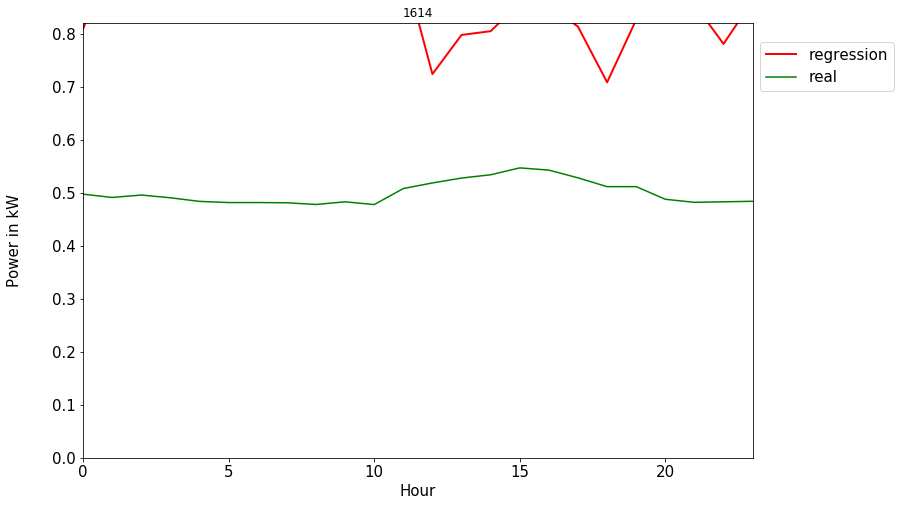

sMAPE: 58.59612834199061
MAPE: 75.65422016382712


<Figure size 432x288 with 0 Axes>

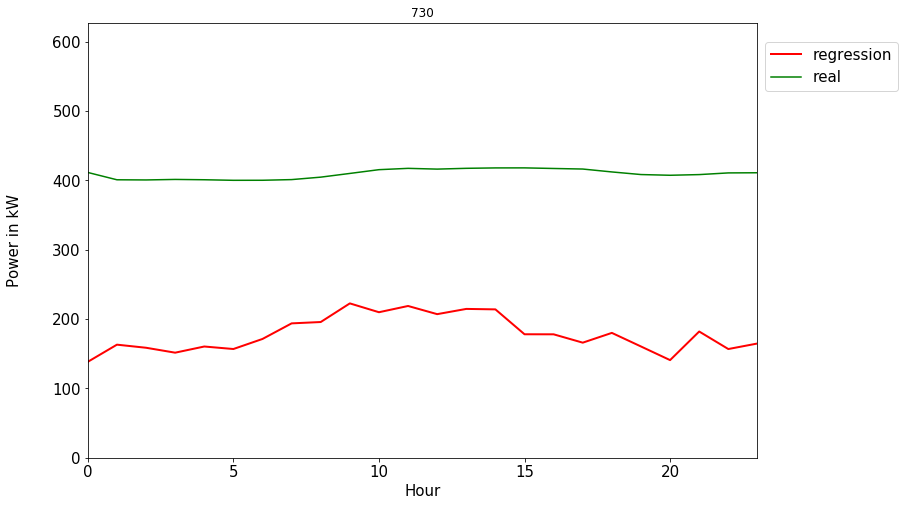

sMAPE: 58.59612834199061
MAPE: 56.42800656414231


<Figure size 432x288 with 0 Axes>

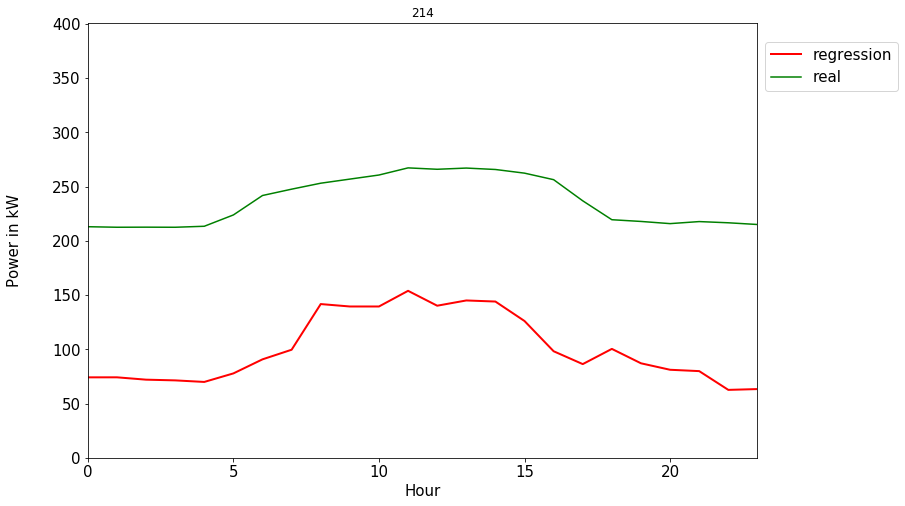

sMAPE: 58.59612834199061
MAPE: 58.07245048342969


<Figure size 432x288 with 0 Axes>

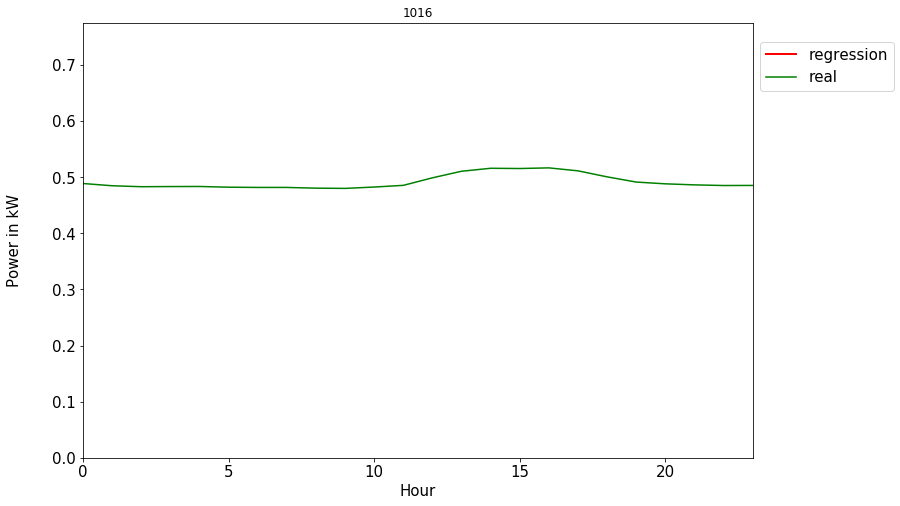

sMAPE: 58.59612834199061
MAPE: 126.36555350710299


<Figure size 432x288 with 0 Axes>

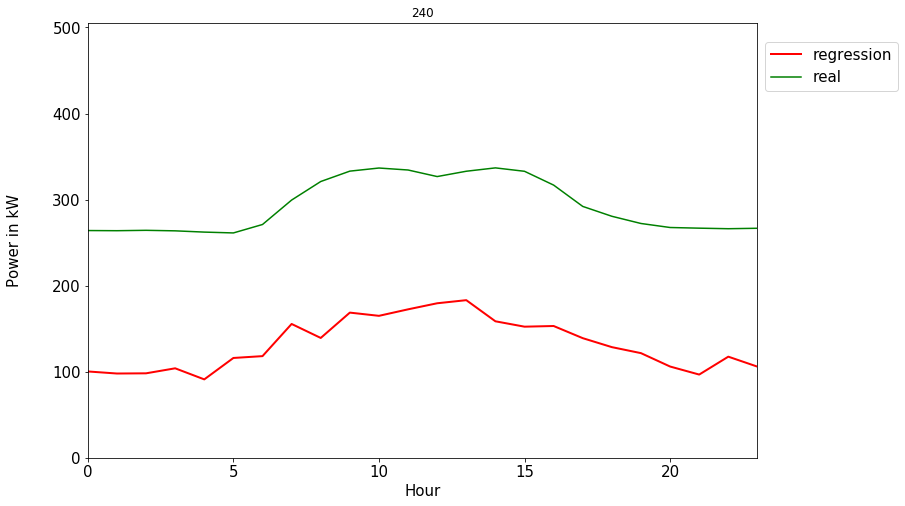

sMAPE: 58.59612834199061
MAPE: 55.42171083555575


<Figure size 432x288 with 0 Axes>

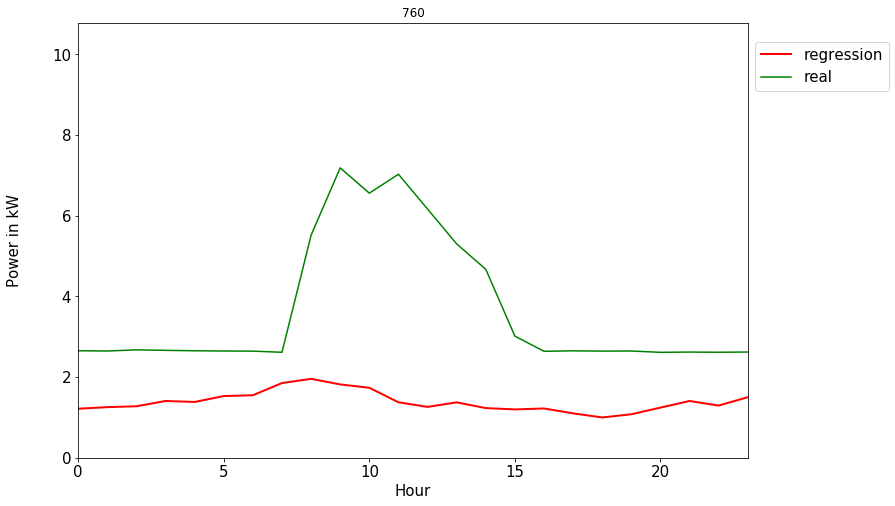

sMAPE: 58.59612834199061
MAPE: 57.19743786294913


<Figure size 432x288 with 0 Axes>

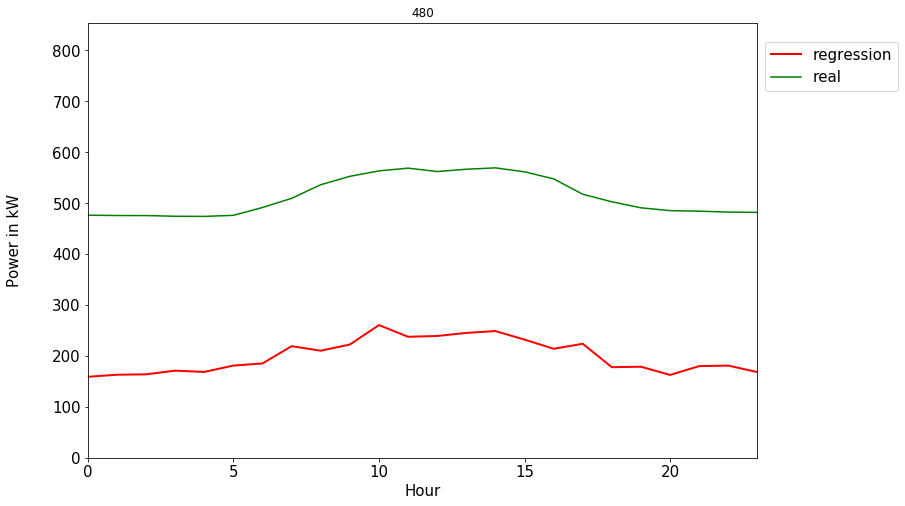

sMAPE: 58.59612834199061
MAPE: 61.32392813588672


<Figure size 432x288 with 0 Axes>

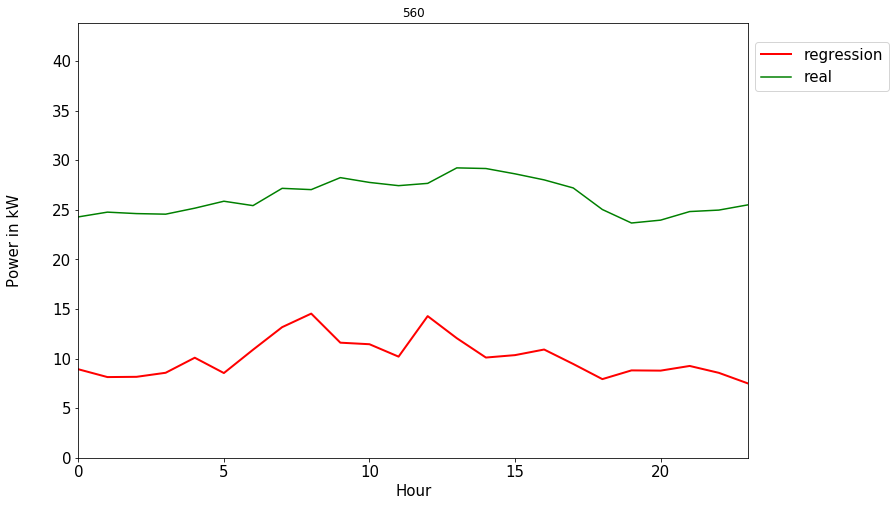

sMAPE: 58.59612834199061
MAPE: 61.69085554098911


<Figure size 432x288 with 0 Axes>

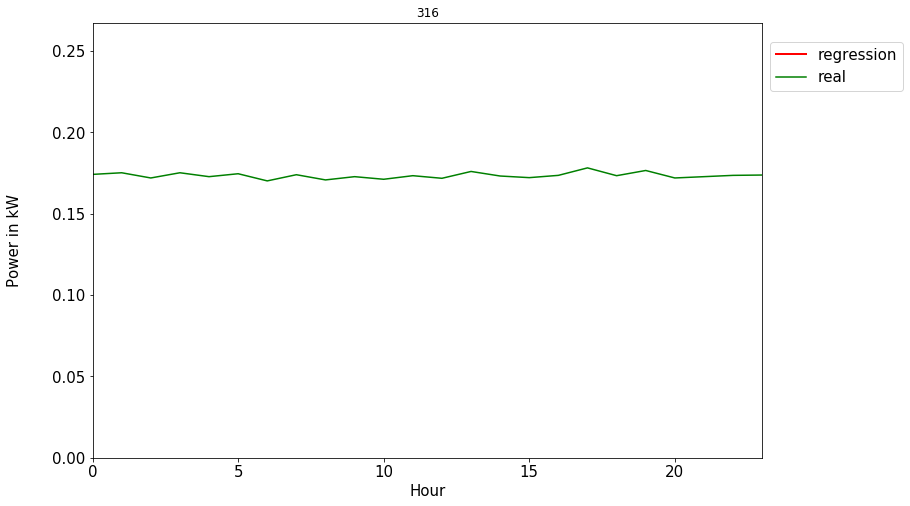

sMAPE: 58.59612834199061
MAPE: 849.915095815655


<Figure size 432x288 with 0 Axes>

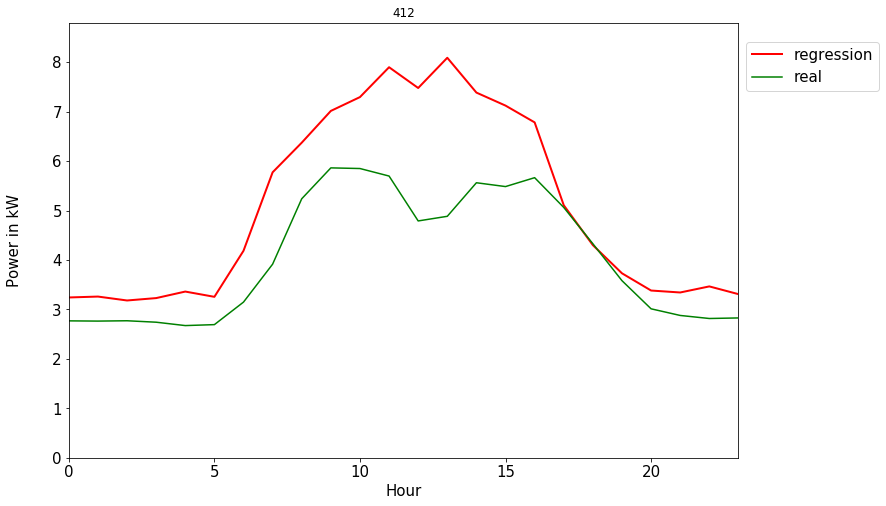

sMAPE: 58.59612834199061
MAPE: 24.062898634132864


<Figure size 432x288 with 0 Axes>

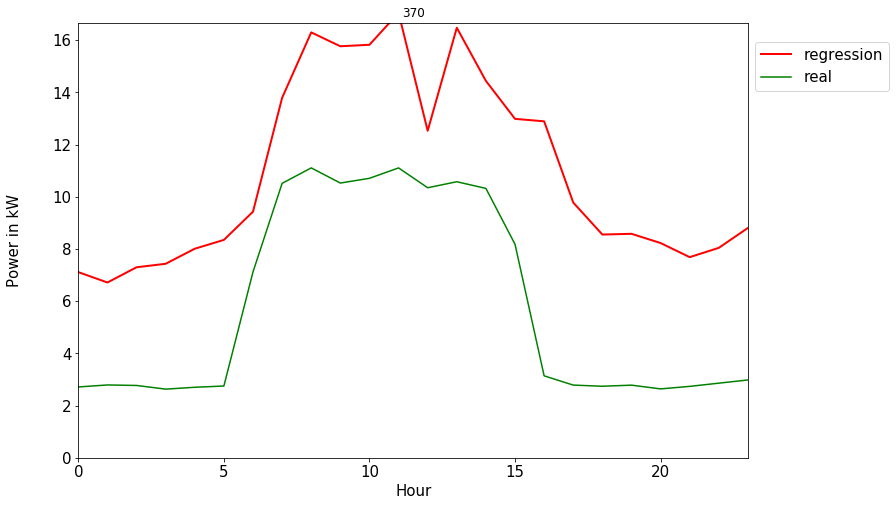

sMAPE: 58.59612834199061
MAPE: 134.86770833041462


<Figure size 432x288 with 0 Axes>

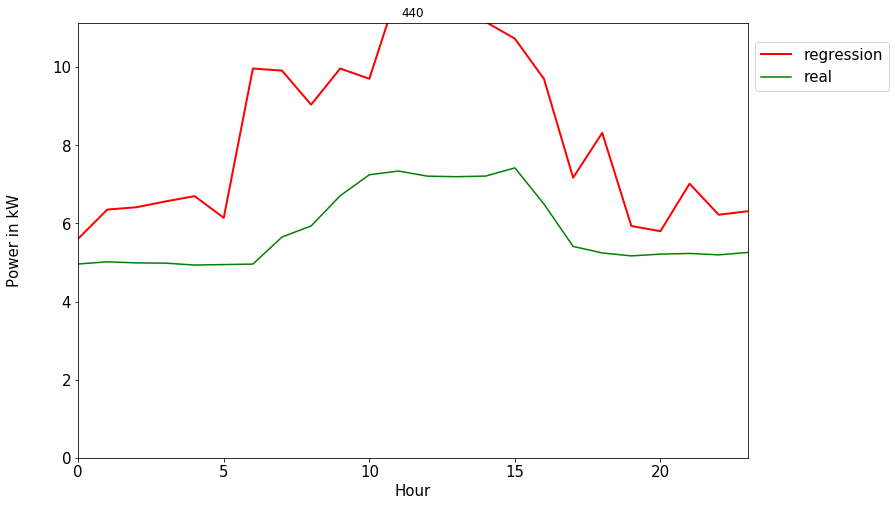

sMAPE: 58.59612834199061
MAPE: 41.79748653540046


<Figure size 432x288 with 0 Axes>

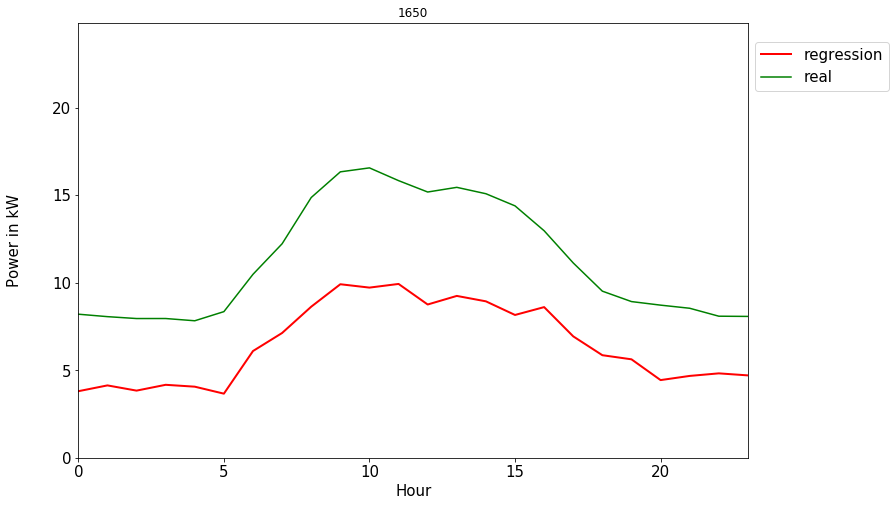

sMAPE: 58.59612834199061
MAPE: 43.28613691924807


<Figure size 432x288 with 0 Axes>

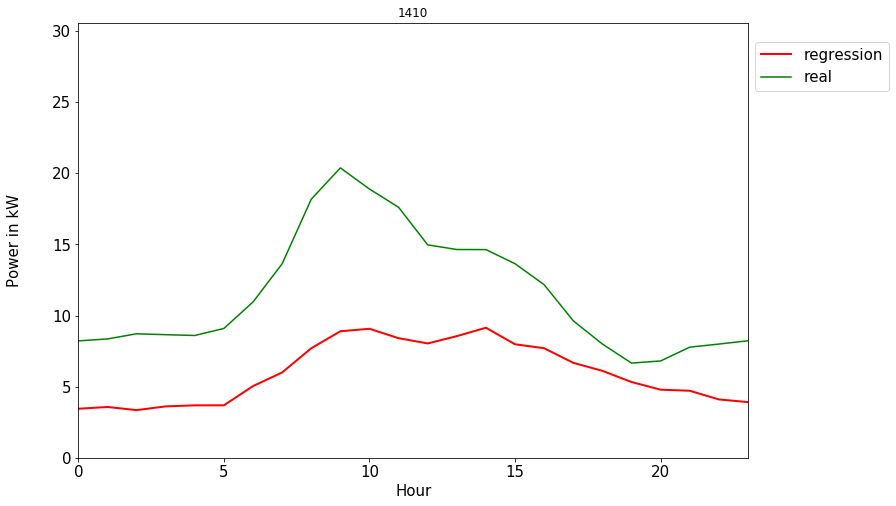

sMAPE: 58.59612834199061
MAPE: 46.99304513337029


<Figure size 432x288 with 0 Axes>

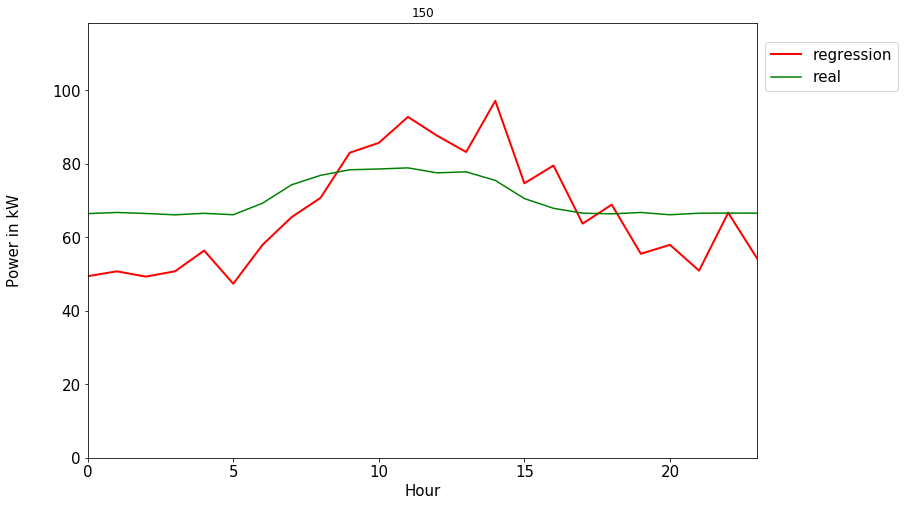

sMAPE: 58.59612834199061
MAPE: 15.097199054596757


<Figure size 432x288 with 0 Axes>

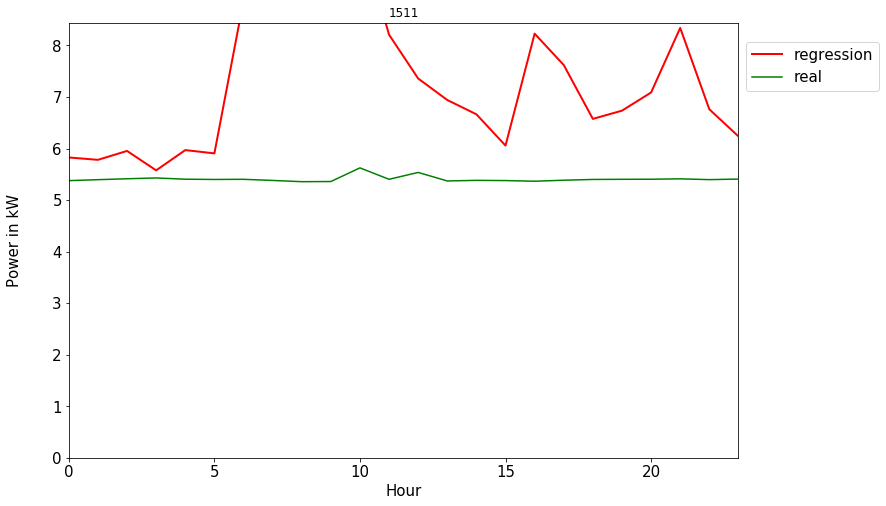

sMAPE: 58.59612834199061
MAPE: 36.746400718093895


<Figure size 432x288 with 0 Axes>

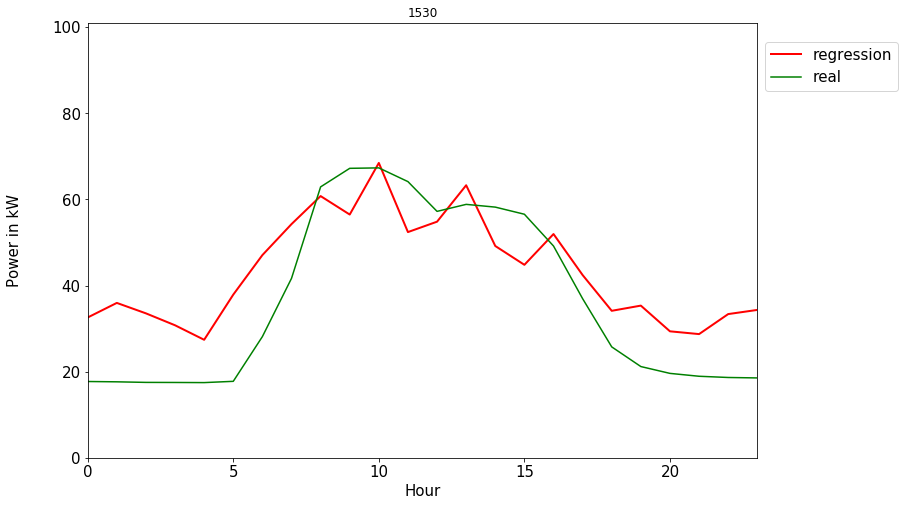

sMAPE: 58.59612834199061
MAPE: 45.66096623937835


<Figure size 432x288 with 0 Axes>

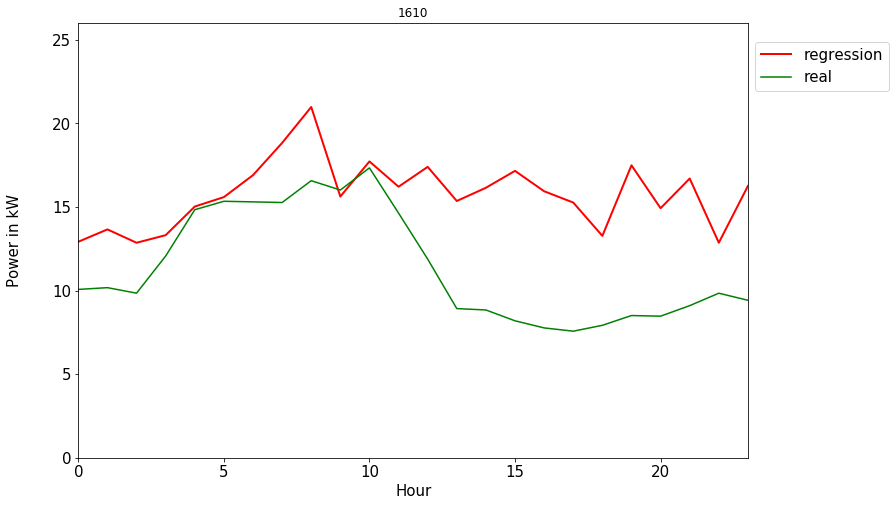

sMAPE: 58.59612834199061
MAPE: 47.324700074860424


<Figure size 432x288 with 0 Axes>

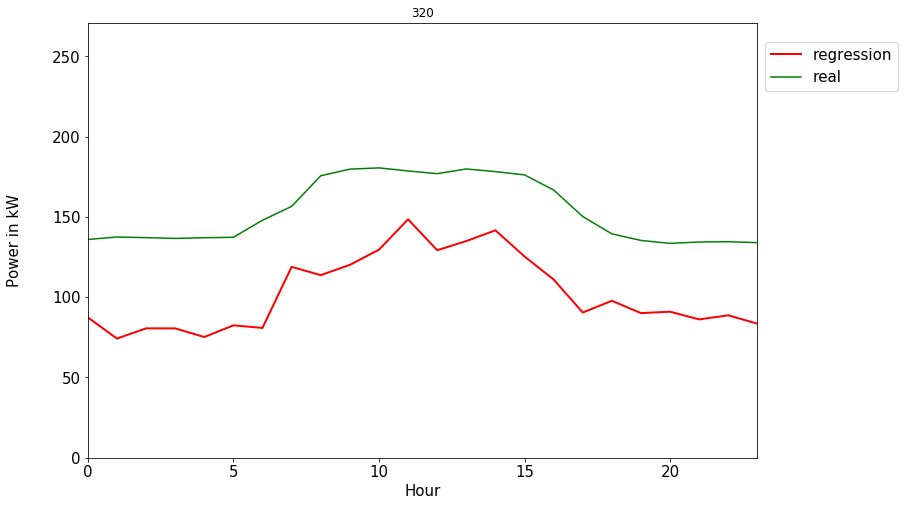

sMAPE: 58.59612834199061
MAPE: 33.70994806144065


<Figure size 432x288 with 0 Axes>

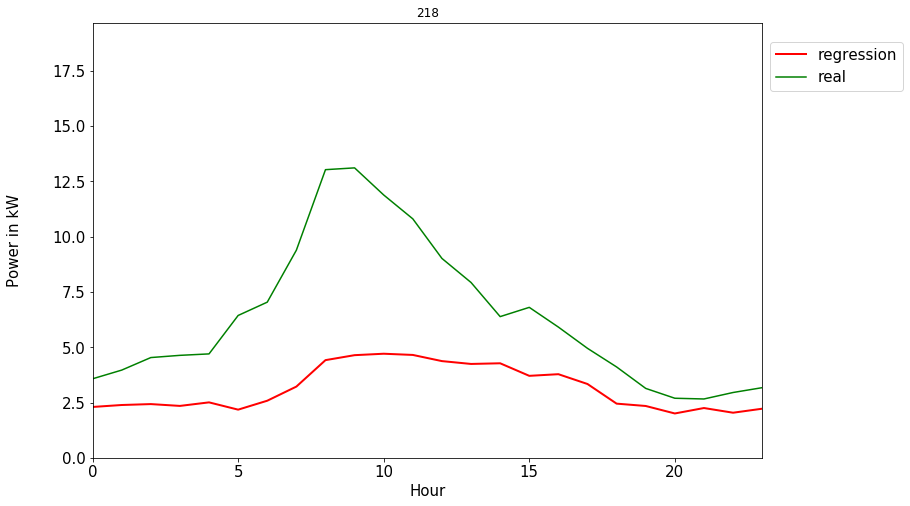

sMAPE: 58.59612834199061
MAPE: 44.74623911625486


<Figure size 432x288 with 0 Axes>

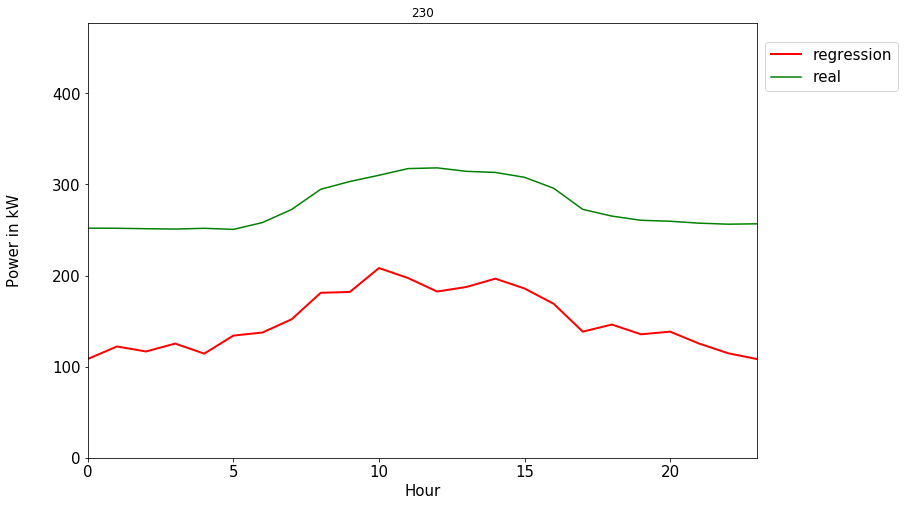

sMAPE: 58.59612834199061
MAPE: 46.22194058727238


<Figure size 432x288 with 0 Axes>

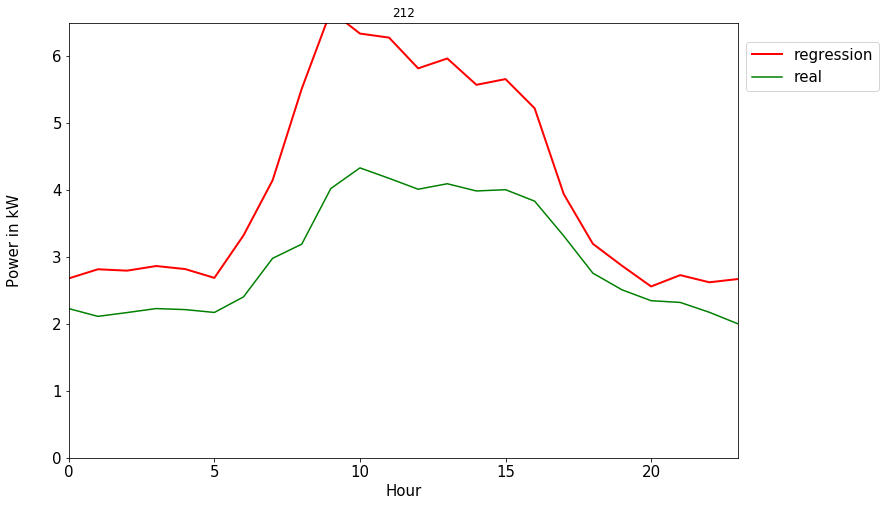

sMAPE: 58.59612834199061
MAPE: 33.86109735370845


<Figure size 432x288 with 0 Axes>

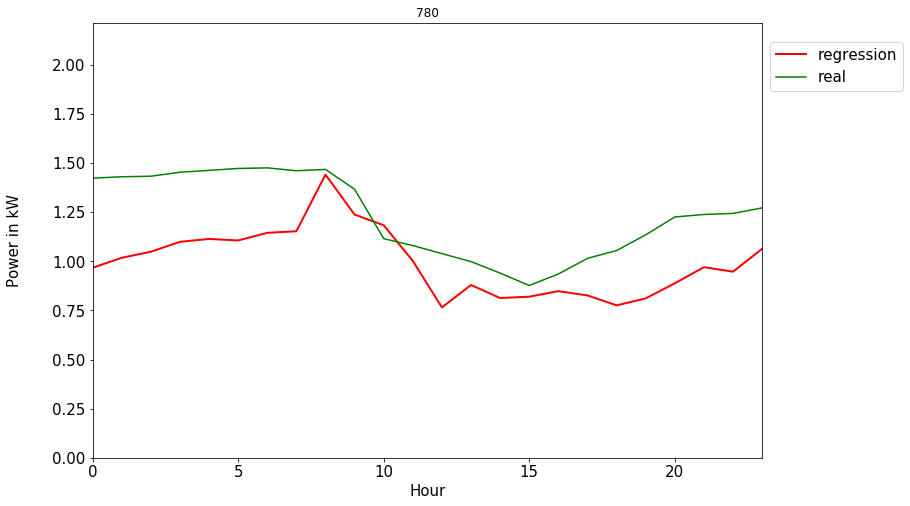

sMAPE: 58.59612834199061
MAPE: 19.142456121663418


<Figure size 432x288 with 0 Axes>

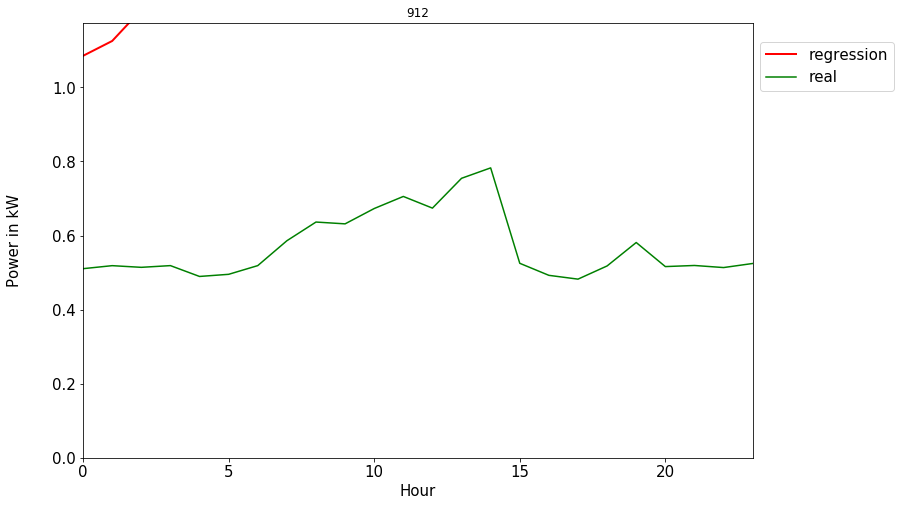

sMAPE: 58.59612834199061
MAPE: 152.1617405434446


Total sMAPE: 60.766355317619926
Total MAPE: 88.96044832493422


<Figure size 432x288 with 0 Axes>

In [50]:
if regression_results:
    test_predictions1 = test_reg_predictions.copy()
    RCV_MAPES = []
    RCV_sMAPES = []
    RY_MAPES = []
    RY_sMAPES = []
    Rstd_MAPES = []
    Rstd_sMAPES = []


    for m in range(len(cv_sMAPES)):
        aux_sMAPES = []
        aux_MAPES = []
        for i in range(len(y_train)):
            aux_sMAPES.append(symmetric_mean_absolute_percentage_error(y_train.iloc[i,:],cv_reg_predictions[m].iloc[i,:]))
            aux_MAPES.append(mean_absolute_percentage_error(y_train.iloc[i,:],cv_reg_predictions[m].iloc[i,:]))
        RCV_MAPES.append(np.mean(aux_MAPES))
        RCV_sMAPES.append(np.mean(aux_sMAPES))


    for m in range(len(test_sMAPES)):
        aux_sMAPES = []
        aux_MAPES = []
        for i in range(len(y_test)):
            aux_sMAPES.append(symmetric_mean_absolute_percentage_error(y_test.iloc[i,:],test_reg_predictions[m].iloc[i,:]))
            aux_MAPES.append(mean_absolute_percentage_error(y_test.iloc[i,:],test_reg_predictions[m].iloc[i,:]))
        RY_MAPES.append(np.mean(aux_MAPES))
        RY_sMAPES.append(np.mean(aux_sMAPES)) 
        Rstd_MAPES.append(np.std(aux_MAPES))
        Rstd_sMAPES.append(np.std(aux_sMAPES)) 

    print('\nsMAPE')
    print('CV sMAPE:      ', RCV_sMAPES)
    print('Test sMAPE:    ', RY_sMAPES)
    print('Test sMAPE std:', Rstd_sMAPES)
    print('\nMAPE')
    print('CV MAPE:       ', RCV_MAPES)
    print('Test MAPE:     ', RY_MAPES)
    print('Test MAPE std: ', Rstd_MAPES)
    
    
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 

    for i in range(0,len(y_test)):

        plt.figure(figsize = (15,9))
        (test_reg_predictions[0].transpose()[i]).plot(c = 'y', lw = 2)
        (test_reg_predictions[1].transpose()[i]).plot(c = 'r', lw = 2)
        (test_reg_predictions[2].transpose()[i]).plot(c = 'm', lw = 2)
        (test_reg_predictions[3].transpose()[i]).plot(c = 'c', lw = 2)
        (test_reg_predictions[4].transpose()[i]).plot(c = 'b', lw = 2)
        (y_pred.transpose()[i]).plot(c = 'k', lw = 3)
        y_test.transpose().iloc[:,i].plot(legend = True, c = 'g', ylim = (0,y_test.transpose().iloc[:,i].max()*1.5))
        plt.title(y_test.index[i])
        plt.legend(['linear regression','support-vector machine','random forest','gradient boosting DT','artificial neural network','ensemble','real load profile'],loc='center left', fontsize = 15, bbox_to_anchor=(1.0, 0.7))
        plt.xlabel('Hour', fontsize = 15)
        plt.ylabel('Power in kW', fontsize = 15, labelpad = 20)
        plt.show()
        plt.clf()    
        
    y_pred = test_regression
    total_sMAPE = 0
    total_MAPE = 0
    n = len(y_test)

    for i in range(0,len(y_test)):

        plt.figure(figsize = (12,8))
        (y_pred.transpose()[i]).plot(c = 'r', lw = 2)
        y_test.transpose().iloc[:,i].plot(legend = True, c = 'g', ylim = (0,y_test.transpose().iloc[:,i].max()*1.5))
        plt.title(y_test.index[i])
        plt.legend(['regression','real'],loc='center left', bbox_to_anchor=(1.0, 0.9), fontsize = 15)
        plt.xlabel('Hour', fontsize = 15)
        plt.ylabel('Power in kW', fontsize = 15, labelpad=30)
        plt.show()
        plt.clf()

        test_sMAPEe = symmetric_mean_absolute_percentage_error(y_test.iloc[i,:], y_pred.iloc[i,:])
        total_sMAPE = total_sMAPE + test_sMAPE/(n-1)
        print('sMAPE:',test_sMAPE)
        test_MAPE = mean_absolute_percentage_error(y_test.iloc[i,:], y_pred.iloc[i,:])
        total_MAPE = total_MAPE + test_MAPE/(n-1)
        print('MAPE:',test_MAPE)

    print('\n\nTotal sMAPE:',total_sMAPE)
    print('Total MAPE:',total_MAPE)

# - - - - - - - - - - - - - - - - - - - - CLASSIFICATION - - - - - - - - - - - - - - - - - - - - - - - - -

In [72]:
seed = 42
test_size = 0.2
cv = 6

classification = True # If False, directly uses the real clusters instead of predicting them
ensemble = True # Classification ensemble

# Select algorithms for maximum power regression
lasso_pred = True
svr_pred = True
rf_pred = True
lgbm_pred = True
ens_pred = True

# Show classification results
classification_results = False

In [73]:
dataset, profiles, columns_to_scale = process_data(task = 'classification', fillna = True, verbose = 1)

# Clustering and Classification
if classification == True:

    # K-Means clustering of load profiles
    print('Clustering...')
    x_train, x_test, y_train, y_test = train_test_split(dataset, profiles, test_size = test_size, random_state = seed)
    c = 5
    model = KMeans(n_clusters = c, random_state = 0)
    model.fit((y_train.transpose()/y_train.transpose().max()).transpose())
    train_labels = model.predict((y_train.transpose()/y_train.transpose().max()).transpose())
    test_labels = model.predict((y_test.transpose()/y_test.transpose().max()).transpose())

    # Classification of load profiles using different algorithms
    cv_labels = pd.DataFrame([],columns = ['LGBMC','RFC','SVC','ENS'])
    pred_labels = pd.DataFrame([],columns = ['LGBMC','RFC','SVC','ENS'])
    scores = []

    # LGBM Classification
    print('\nLightGBM Classification...')
    dataset, profiles, columns_to_scale = process_data(task = 'classification', fillna = False)
    x_train, x_test, y_train, y_test = train_test_split(dataset,profiles,test_size = test_size, random_state = seed)
    
    robust_scaler = RobustScaler(with_centering=False, quantile_range=(0.0, 98.0), copy=True)
    x_train_sc = x_train.copy()
    x_train_sc[columns_to_scale] = robust_scaler.fit_transform(x_train[columns_to_scale])
    x_test_sc = x_test.copy()
    x_test_sc[columns_to_scale] = robust_scaler.transform(x_test[columns_to_scale])

    grid_lgb = {'learning_rate':[0.05, 0.2],
                'n_estimators' : [25, 50, 75, 100, 150, 200],
                'num_leaves' : [2, 3, 4, 5],
                'max_depth' : [2, 3, 4],
                'colsample_bytree' : [0.3, 0.4, 0.5],
                'reg_alpha' : [0, 1],
                'reg_lambda' : [0, 1]}

    gbm = LGBMClassifier(boosting_type = 'gbdt', objective = 'multiclass', num_class = c, random_state = 0)
    gbm_cv = GridSearchCV(gbm, grid_lgb, scoring = 'f1_micro', cv = 5, iid = True, n_jobs = -1, pre_dispatch = '2*n_jobs',verbose=0)
    gbm_cv.fit(x_train_sc, train_labels)
    #print(gbm_cv.best_params_)
    #print('F1 score: ' + str(gbm_cv.best_score_))
    scores.append(gbm_cv.best_score_)
    gbm = gbm_cv.best_estimator_
    cv_labels['LGBMC'] = cross_val_predict(gbm,x_train_sc, train_labels, cv = 5)
    y_pred = gbm_cv.predict(x_test_sc)
    #print('Test F1 score: ' + str(sklearn.metrics.f1_score(test_labels, y_pred, average = 'micro')))
    pred_labels['LGBMC'] = y_pred

    # Random Forest Classification
    print('\nRandom Forest Classification...')
    dataset, profiles, columns_to_scale = process_data(task = 'classification', fillna = True)
    x_train, x_test, y_train, y_test = train_test_split(dataset,profiles,test_size = test_size, random_state = seed)

    robust_scaler = RobustScaler(with_centering=False, quantile_range=(0.0, 98.0), copy=True)
    x_train_sc = x_train.copy()
    x_train_sc[columns_to_scale] = robust_scaler.fit_transform(x_train[columns_to_scale])
    x_test_sc = x_test.copy()
    x_test_sc[columns_to_scale] = robust_scaler.transform(x_test[columns_to_scale])

    grid_rf = {'n_estimators':np.arange(30,230,10),
           'max_depth': [2, 3, 4, 5, 6, 7],
           'max_features': ['sqrt'],
           'min_samples_leaf': [2]}

    rfc = RandomForestClassifier(criterion = 'gini', random_state = 0)
    rfc_cv = GridSearchCV(rfc, grid_rf, scoring = 'f1_micro', cv = 5, iid = True, n_jobs = -1, pre_dispatch = '2*n_jobs',verbose=0)
    rfc_cv.fit(x_train_sc, train_labels)
    #print(rfc_cv.best_params_)
    #print('F1 score: ' + str(rfc_cv.best_score_))
    scores.append(rfc_cv.best_score_)
    rfc = rfc_cv.best_estimator_
    cv_labels['RFC'] = cross_val_predict(rfc,x_train_sc, train_labels, cv = 5)
    y_pred = rfc_cv.predict(x_test_sc)
    #print('Test F1 score: ' + str(sklearn.metrics.f1_score(test_labels, y_pred, average = 'micro')))
    pred_labels['RFC'] = y_pred


    # SV Classification
    print('\nSupport Vector Machine Classification...')
    
    grid_svc = {'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
                'C': [100000, 10000, 1000, 100, 10, 1, 0.1]}

    svc = SVC(kernel = 'rbf', decision_function_shape = 'ovr', random_state = 0)
    svc_cv = GridSearchCV(svc, grid_svc, scoring = 'f1_micro', cv = 5, iid = True, n_jobs = -1, pre_dispatch = '2*n_jobs',verbose=0)
    svc_cv.fit(np.log(x_train_sc+1), train_labels)
    #print(svc_cv.best_params_)
    #print('F1 score: ' + str(svc_cv.best_score_))
    scores.append(svc_cv.best_score_)
    svc = svc_cv.best_estimator_
    cv_labels['SVC'] = cross_val_predict(svc,np.log(x_train_sc+1), train_labels, cv = 5)
    y_pred = svc_cv.predict(np.log(x_test_sc+1))
    #print('Test F1 score: ' + str(sklearn.metrics.f1_score(test_labels, y_pred, average = 'micro')))
    pred_labels['SVC'] = y_pred

    # Ensemble Classification
    if ensemble == True:
        
        print('\nEnsemble Classification...')
        grid_ens = {'n_estimators':np.arange(10, 230, 10),
               'max_depth': [2, 3, 4, 5, 6, 7],
               'max_features': ['sqrt'],
               'min_samples_leaf': [2]}
        
        x_train_sc['LGBMC'] = np.array(cv_labels['LGBMC'])
        x_train_sc['RFC'] = np.array(cv_labels['RFC'])
        x_train_sc['SVC'] = np.array(cv_labels['SVC'])
        x_test_sc['LGBMC'] = np.array(pred_labels['LGBMC'])
        x_test_sc['RFC'] = np.array(pred_labels['RFC'])
        x_test_sc['SVC'] = np.array(pred_labels['SVC'])
        
        
        ens = RandomForestClassifier(criterion = 'gini', random_state = 0)
        ens_cv = GridSearchCV(ens, grid_ens, scoring = 'f1_micro', cv = 5, iid = True, n_jobs = -1, pre_dispatch = '2*n_jobs',verbose=0)
        ens_cv.fit(x_train_sc, train_labels)
        #print(ens_cv.best_params_)
        #print('F1 score: ' + str(ens_cv.best_score_))
        scores.append(ens_cv.best_score_)
        cv_labels['ENS'] = cross_val_predict(ens, x_train_sc, train_labels, cv = 5)  
        ens = ens_cv.best_estimator_
        y_pred = ens_cv.predict(x_test_sc)
        #print('Test F1 score: ' + str(sklearn.metrics.f1_score(test_labels, y_pred, average = 'micro')))
        pred_labels['ENS'] = y_pred
        
    test_clusters = pred_labels.iloc[:,scores.index(max(scores[0:3]))]
    cv_clusters = cv_labels.iloc[:,scores.index(max(scores[0:3]))]
            
else:

    print('Clustering...')
    c = 7
    model = KMeans(n_clusters = c, random_state = 0)
    model.fit((profiles.transpose()/profiles.transpose().max()).transpose())
    labels = model.predict((profiles.transpose()/profiles.transpose().max()).transpose())

    x_train, x_test, train_labels, test_labels = train_test_split(dataset, labels, test_size = test_size, random_state = seed)
    test_clusters = test_labels
    cv_clusters = train_labels


Loading files...  

Processing data... 

Clustering...

LightGBM Classification...

Random Forest Classification...

Support Vector Machine Classification...

Ensemble Classification...


C:\Users\danie\Anaconda3b\envs\Python3.7\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\danie\Anaconda3b\envs\Python3.7\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\danie\Anaconda3b\envs\Python3.7\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\danie\Anaconda3b\envs\Python3.7\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dan

In [75]:

# Regression of maximum power
cv_sMAPES = []
test_sMAPES = []
cv_MAPES = []
test_MAPES = []
cv_predictions = []
test_predictions = []


dataset, profiles, columns_to_scale = process_data(task = 'regression', fillna = True)
x_train, x_test, y_train, y_test = train_test_split(dataset,profiles,test_size = test_size, random_state = seed)

robust_scaler = RobustScaler(with_centering=False, quantile_range=(0.0, 98.0), copy=True)
x_train_sc = x_train.copy()
x_train_sc[columns_to_scale] = robust_scaler.fit_transform(x_train[columns_to_scale])
x_test_sc = x_test.copy()
x_test_sc[columns_to_scale] = robust_scaler.transform(x_test[columns_to_scale])

x_train_log = np.log(x_train_sc+1)
x_test_log = np.log(x_test_sc+1)

y_train = y_train.transpose().max()
y_test = y_test.transpose().max()
# Y log
y_train_log = np.log(y_train + 1)
y_test_log = np.log(y_test + 1)


if lasso_pred == True:
    print('\n','Fitting Lasso...')

    y_pred = pd.DataFrame([])
    cv_pred = pd.DataFrame([])

    lasso = Lasso(alpha = 0.1, max_iter=1000000, fit_intercept = True, normalize = False, precompute = True, random_state = 0)
    cv_pred = np.exp(cross_val_predict(lasso, x_train_sc, y_train_log, cv = cv))-1
    cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)
    cv_MAPE = mean_absolute_percentage_error(y_train,cv_pred)    
    lasso.fit(x_train_sc, y_train_log)
    y_pred = np.exp(lasso.predict(x_test_sc))-1
    test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)
    test_MAPE = mean_absolute_percentage_error(y_test,y_pred)


if svr_pred == True:
    print('\n','Fitting Support Vector Machine...')
    
    y_pred = pd.DataFrame([])
    cv_pred = pd.DataFrame([])

    best_params = {}
    best_sMAPE = np.inf
    
    grid_svr = {'gamma': [100, 10, 1, 0.1, 0.001, 0.0001, 0.00001],
                'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001],
                'epsilon' : [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]}
    
    space_svr = ParameterGrid(grid_svr)
    
    for params in space_svr:

        svr = SVR(kernel = 'rbf', **params)
        cv_pred = np.exp(cross_val_predict(svr, x_train_sc, y_train_log, cv = cv))-1
        cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)
        svr.fit(x_train_sc, y_train_log)
        y_pred = np.exp(svr.predict(x_test_sc))-1
        test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)
        
        if cv_sMAPE < best_sMAPE:
            best_sMAPE = cv_sMAPE
            best_params = params

    svr = SVR(kernel = 'rbf', **best_params)
    cv_pred = np.exp(cross_val_predict(svr, x_train_log, y_train_log, cv = cv))-1
    cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)
    cv_MAPE = mean_absolute_percentage_error(y_train,cv_pred)
    svr.fit(x_train_log, y_train_log)
    y_pred = np.exp(svr.predict(x_test_log))-1
    test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)
    test_MAPE = mean_absolute_percentage_error(y_test,y_pred)
    
    cv_sMAPES.append(cv_sMAPE)
    test_sMAPES.append(test_sMAPE)
    cv_MAPES.append(cv_MAPE)
    test_MAPES.append(test_MAPE)
    cv_predictions.append(cv_pred)
    test_predictions.append(y_pred)
    


if rf_pred == True:
    print('\n','Fitting Random Forest...')

    y_pred = pd.DataFrame([])
    cv_pred = pd.DataFrame([])

    best_params = {}
    best_sMAPE = np.inf
    
    grid_rf = {'n_estimators': [25,50,75,100,150,200,250,300,350],
                'max_depth':[3, 4, 5, 6, 7],
                'max_features' : ['sqrt'],
                'min_samples_leaf':[2, 3, 4, 5, 6],
                'criterion': ['mse']}
    
    space_rf = ParameterGrid(grid_rf)
    
    for params in space_rf:
        
        rf = RandomForestRegressor(**params, random_state = 0)
        cv_pred = np.exp(cross_val_predict(rf, x_train_sc, y_train_log, cv = cv))-1
        cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)
        rf.fit(x_train_sc, y_train_log)
        y_pred = np.exp(rf.predict(x_test_sc))-1
        test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)

        if cv_sMAPE < best_sMAPE:
            best_sMAPE = cv_sMAPE
            best_params = params

    rf = RandomForestRegressor(**best_params, random_state = 0)
    cv_pred = np.exp(cross_val_predict(rf, x_train_sc, y_train_log, cv = cv))-1
    cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)
    cv_MAPE = mean_absolute_percentage_error(y_train,cv_pred)
    rf.fit(x_train_sc, y_train_log)
    y_pred = np.exp(rf.predict(x_test_sc))-1
    test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)
    test_MAPE = mean_absolute_percentage_error(y_test,y_pred)

    cv_sMAPES.append(cv_sMAPE)
    test_sMAPES.append(test_sMAPE)
    cv_MAPES.append(cv_MAPE)
    test_MAPES.append(test_MAPE)
    cv_predictions.append(cv_pred)
    test_predictions.append(y_pred)

    
if lgbm_pred == True:
    print('\n','Fitting LightGBM...')
    dataset, profiles, columns_to_scale = process_data(task = 'regression', fillna = True)
    x_train, x_test, y_train, y_test = train_test_split(dataset,profiles,test_size = test_size, random_state = seed)
    
    robust_scaler = RobustScaler(with_centering=False, quantile_range=(0.0, 98.0), copy=True)
    x_train_sc = x_train.copy()
    x_train_sc[columns_to_scale] = robust_scaler.fit_transform(x_train[columns_to_scale])
    x_test_sc = x_test.copy()
    x_test_sc[columns_to_scale] = robust_scaler.transform(x_test[columns_to_scale])

    y_train = y_train.transpose().max()
    y_test = y_test.transpose().max()        
    # Y log
    y_train_log = np.log(y_train + 1)
    y_test_log = np.log(y_test + 1)


    y_pred = pd.DataFrame([])
    cv_pred = pd.DataFrame([])

    best_params = {}
    best_sMAPE = np.inf
    
    grid_lgbm = {'learning_rate':[0.02, 0.05, 0.2],
                'n_estimators' : [50, 100, 150, 200, 250],
                'num_leaves' : [3, 5, 7, 10],
                'max_depth' : [2, 3, 4, 5],
                'colsample_bytree' : [0.3, 0.45, 0.6],
                'objective' : ['regression'],
                'reg_alpha' : [0, 1],
                'reg_lambda' : [0, 1]}
    
    space_lgbm = ParameterGrid(grid_lgbm)
    
    for params in space_lgbm:
        
        lgbm = LGBMRegressor(boosting_type = 'gbdt', random_state = 0, **params)
        cv_pred = np.exp(cross_val_predict(lgbm, x_train_sc, y_train_log, cv = cv))-1
        cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)
        lgbm.fit(x_train_sc, y_train_log)
        y_pred = np.exp(lgbm.predict(x_test_sc))-1
        test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)

        if cv_sMAPE < best_sMAPE:
            best_sMAPE = cv_sMAPE
            best_params = params

    lgbm = LGBMRegressor(boosting_type = 'gbdt', random_state = 0, **best_params)
    cv_pred = np.exp(cross_val_predict(lgbm, x_train_sc, y_train_log, cv = cv))-1
    cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)
    cv_MAPE = mean_absolute_percentage_error(y_train,cv_pred)
    lgbm.fit(x_train_sc, y_train_log)
    y_pred = np.exp(lgbm.predict(x_test_sc))-1
    test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)
    test_MAPE = mean_absolute_percentage_error(y_test,y_pred)
        
    cv_sMAPES.append(cv_sMAPE)
    test_sMAPES.append(test_sMAPE)
    cv_MAPES.append(cv_MAPE)
    test_MAPES.append(test_MAPE)
    cv_predictions.append(cv_pred)
    test_predictions.append(y_pred)
    


if ens_pred == True:
    print('\n','Fitting Ensemble...')

    y_pred = pd.DataFrame([])
    cv_pred = pd.DataFrame([])  
    
    for i in range(len(test_sMAPES)):
        
        x_train_sc[str(i)] = cv_predictions[i] 
        x_test_sc[str(i)] = test_predictions[i] 
        
    best_params = {}
    best_sMAPE = np.inf
    
    for params in space_rf:
        
        rf = RandomForestRegressor(**params, random_state = 0)
        cv_pred = np.exp(cross_val_predict(rf, x_train_sc, y_train_log, cv = cv))-1
        cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)
        rf.fit(x_train_sc, y_train_log)
        y_pred = np.exp(rf.predict(x_test_sc))-1
        test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)

        if cv_sMAPE < best_sMAPE:
            best_sMAPE = cv_sMAPE
            best_params = params


    rf = RandomForestRegressor(**best_params, random_state = 0)
    cv_pred = np.exp(cross_val_predict(rf, x_train_sc, y_train_log, cv = cv))-1
    cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train,cv_pred)
    cv_MAPE = mean_absolute_percentage_error(y_train,cv_pred)
    rf.fit(x_train_sc, y_train_log)
    y_pred = np.exp(rf.predict(x_test_sc))-1
    test_sMAPE = symmetric_mean_absolute_percentage_error(y_test,y_pred)
    test_MAPE = mean_absolute_percentage_error(y_test,y_pred)

    cv_sMAPES.append(cv_sMAPE)
    test_sMAPES.append(test_sMAPE)
    cv_MAPES.append(cv_MAPE)
    test_MAPES.append(test_MAPE)
    cv_predictions.append(cv_pred)
    test_predictions.append(y_pred)   



 Fitting Lasso...

 Fitting Support Vector Machine...

 Fitting Random Forest...

 Fitting LightGBM...

 Fitting Ensemble...


In [81]:
if regression_results:
    
    total_sMAPE = 0
    total_MAPE = 0
    
    n = len(cv_clusters)
    m = cv_sMAPES.index(max(cv_sMAPES))
    cv_pred = pd.DataFrame()
    y_pred = pd.DataFrame()
    x_train, x_test, y_train, y_test = train_test_split(dataset,profiles,test_size = test_size, random_state = seed)

    for i in range(n):
        cv_pred[i] = model.cluster_centers_[cv_clusters[i]] * cv_predictions[m][i]

        cv_sMAPE = symmetric_mean_absolute_percentage_error(y_train.transpose()[y_train.index[i]], cv_pred[i])
        total_sMAPE = total_sMAPE + cv_sMAPE/n
        cv_MAPE = mean_absolute_percentage_error(y_train.transpose()[y_train.index[i]], cv_pred[i])
        total_MAPE = total_MAPE + cv_MAPE/n

    print('CV sMAPE:',total_sMAPE)
    print('CV MAPE:',total_MAPE)

    total_sMAPE = 0
    total_sMAPE = 0
    n = len(test_clusters)

    for i in range(n):

        y_pred[i] = model.cluster_centers_[test_clusters[i]] * test_predictions[m][i]

        plt.figure(figsize= (12,8))
        plt.title(y_test.index[i])
        y_test.transpose()[y_test.index[i]].plot(c = 'g')
        plt.plot(y_pred[i], c = '#389fff')
        plt.axis([0,23,0,(np.max(y_pred[i])+y_test.transpose()[y_test.index[i]].max())])
        plt.legend(['real','clustering'],loc='center left', fontsize = 15, bbox_to_anchor=(1.0, 0.9))
        plt.xlabel('Hour', fontsize = 15)
        plt.ylabel('Power in kW ', fontsize = 15,labelpad=30)
        plt.show()
        plt.clf()

        test_sMAPE = symmetric_mean_absolute_percentage_error(y_test.transpose()[y_test.index[i]], y_pred[i])
        total_sMAPE = total_sMAPE + test_sMAPE/(n-1)
        print('sMAPE:',test_sMAPE)
        test_MAPE = mean_absolute_percentage_error(y_test.transpose()[y_test.index[i]], y_pred[i])
        total_MAPE = total_MAPE + test_MAPE/(n-1)
        print('MAPE:',test_MAPE)

    print('Total sMAPE:',total_sMAPE)
    print('Total MAPE:',total_MAPE)

    cv_classification = cv_pred.transpose()
    test_classification = y_pred.transpose()
    
    
    RCV_MAPES = []
    RCV_sMAPES = []
    RY_MAPES = []
    RY_sMAPES = []
    Rstd_MAPES = []
    Rstd_sMAPES = []



    aux_sMAPES = []
    aux_MAPES = []
    for i in range(len(y_train)):
        aux_sMAPES.append(symmetric_mean_absolute_percentage_error(y_train.iloc[i,:],cv_classification.iloc[i,:]))
        aux_MAPES.append(mean_absolute_percentage_error(y_train.iloc[i,:],cv_classification.iloc[i]))
    RCV_MAPES.append(np.mean(aux_MAPES))
    RCV_sMAPES.append(np.mean(aux_sMAPES))


    aux_sMAPES = []
    aux_MAPES = []
    for i in range(len(y_test)):
        aux_sMAPES.append(symmetric_mean_absolute_percentage_error(y_test.iloc[i,:],test_classification.iloc[i,:]))
        aux_MAPES.append(mean_absolute_percentage_error(y_test.iloc[i,:],test_classification.iloc[i]))
    RY_MAPES.append(np.mean(aux_MAPES))
    RY_sMAPES.append(np.mean(aux_sMAPES)) 
    Rstd_MAPES.append(np.std(aux_MAPES))
    Rstd_sMAPES.append(np.std(aux_sMAPES)) 

    print('\nsMAPE')
    print('CV sMAPE:      ', RCV_sMAPES)
    print('Test sMAPE:    ', RY_sMAPES)
    print('Test sMAPE std:', Rstd_sMAPES)
    print('\nMAPE')
    print('CV MAPE:       ', RCV_MAPES)
    print('Test MAPE:     ', RY_MAPES)
    print('Test MAPE std: ', Rstd_MAPES)

# FINAL RESULTS

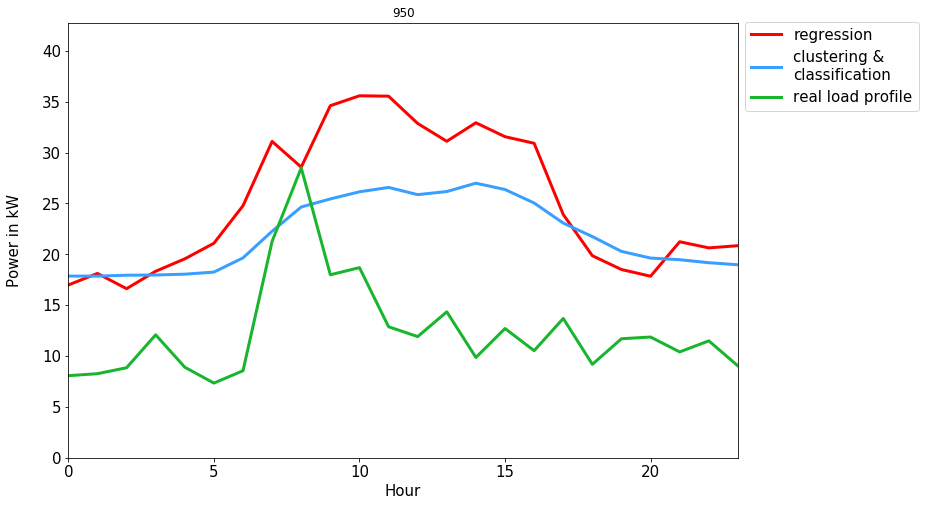

Regression sMAPE: 68.73983092838291
Classification sMAPE: 59.88727781895983
Regression MAPE: 114.69766851059833
Classification MAPE: 91.74261686845973
___________________________________________________


<Figure size 432x288 with 0 Axes>

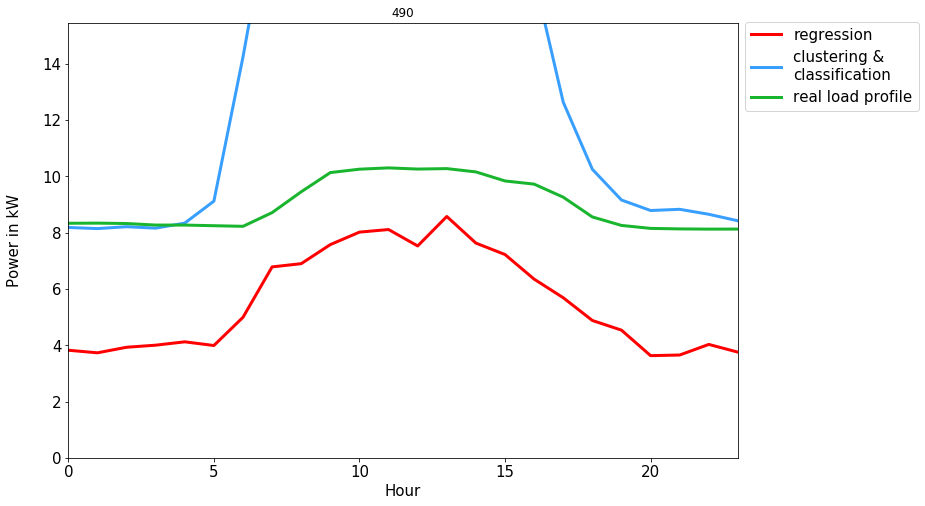

Regression sMAPE: 50.629253170299236
Classification sMAPE: 39.61619358513306
Regression MAPE: 39.29975503126819
Classification MAPE: 63.35762024437038
___________________________________________________


<Figure size 432x288 with 0 Axes>

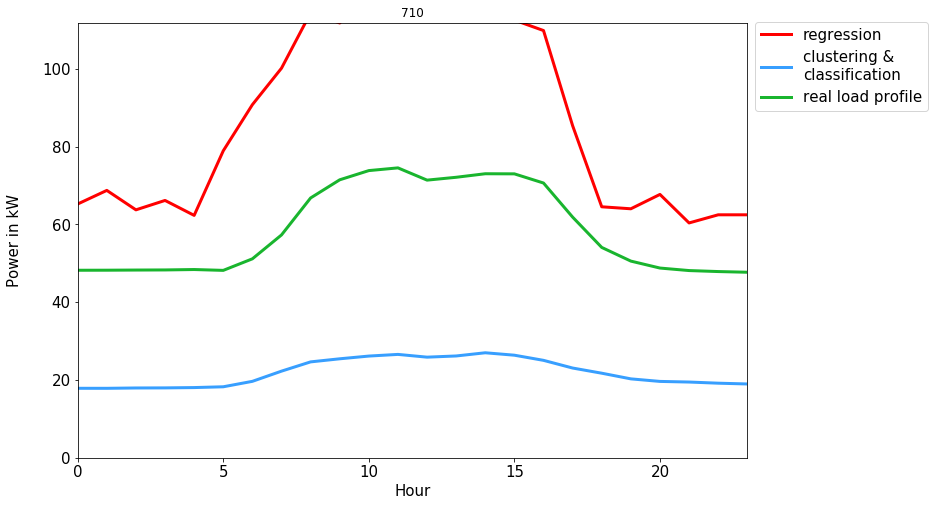

Regression sMAPE: 38.7068507192665
Classification sMAPE: 90.60367776703728
Regression MAPE: 49.40351899923529
Classification MAPE: 62.33554859798242
___________________________________________________


<Figure size 432x288 with 0 Axes>

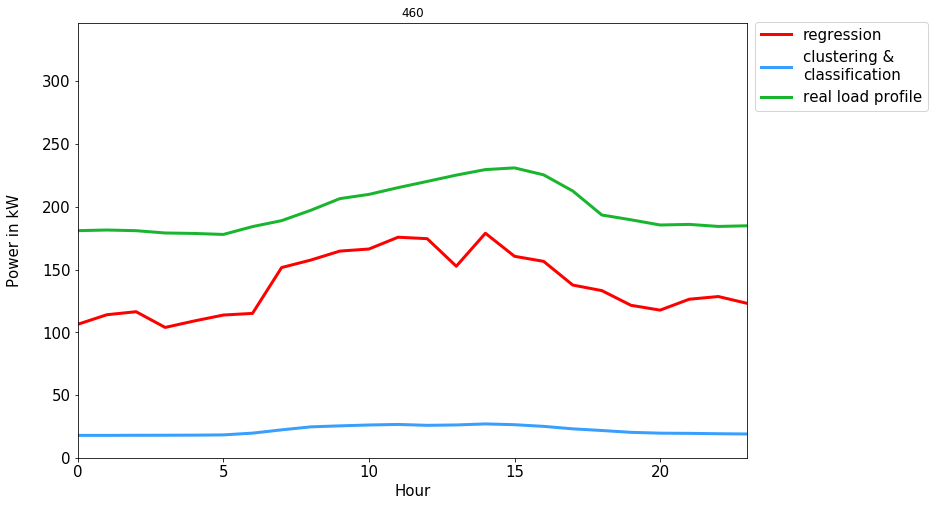

Regression sMAPE: 36.82583736253793
Classification sMAPE: 160.34356991761865
Regression MAPE: 30.7819398993041
Classification MAPE: 88.98809283458546
___________________________________________________


<Figure size 432x288 with 0 Axes>

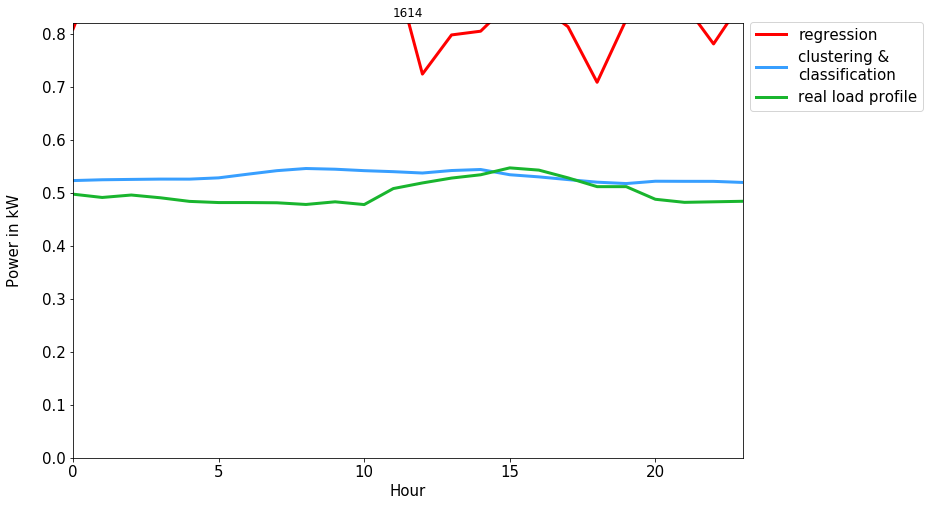

Regression sMAPE: 53.773249233700646
Classification sMAPE: 6.405200287882897
Regression MAPE: 75.65422016382712
Classification MAPE: 6.690723269495832
___________________________________________________


<Figure size 432x288 with 0 Axes>

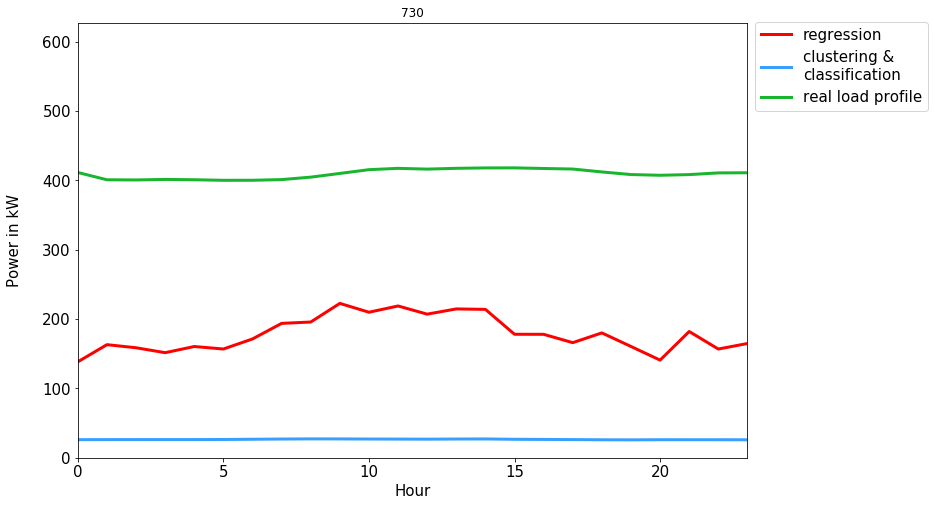

Regression sMAPE: 79.04828759334018
Classification sMAPE: 175.66448023483588
Regression MAPE: 56.42800656414231
Classification MAPE: 93.52183912480783
___________________________________________________


<Figure size 432x288 with 0 Axes>

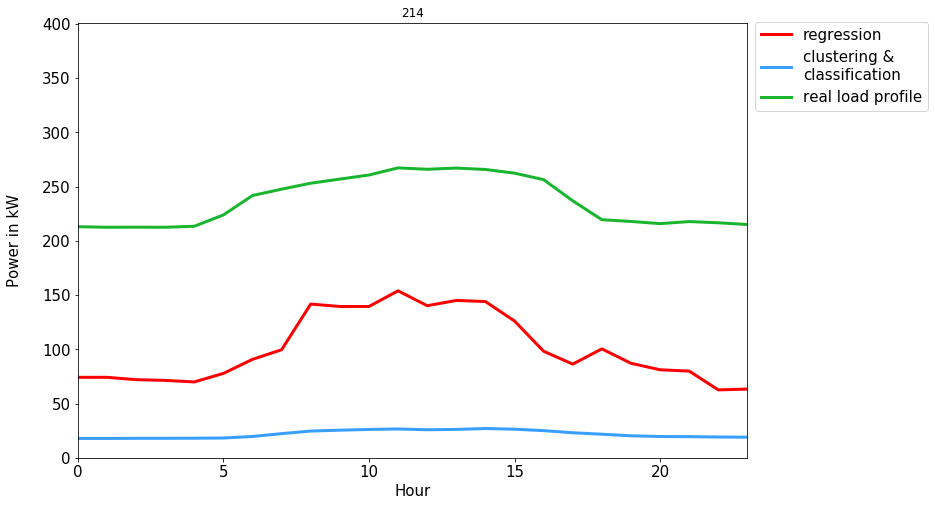

Regression sMAPE: 82.98319624298944
Classification sMAPE: 166.259371250531
Regression MAPE: 58.07245048342969
Classification MAPE: 90.78356311394074
___________________________________________________


<Figure size 432x288 with 0 Axes>

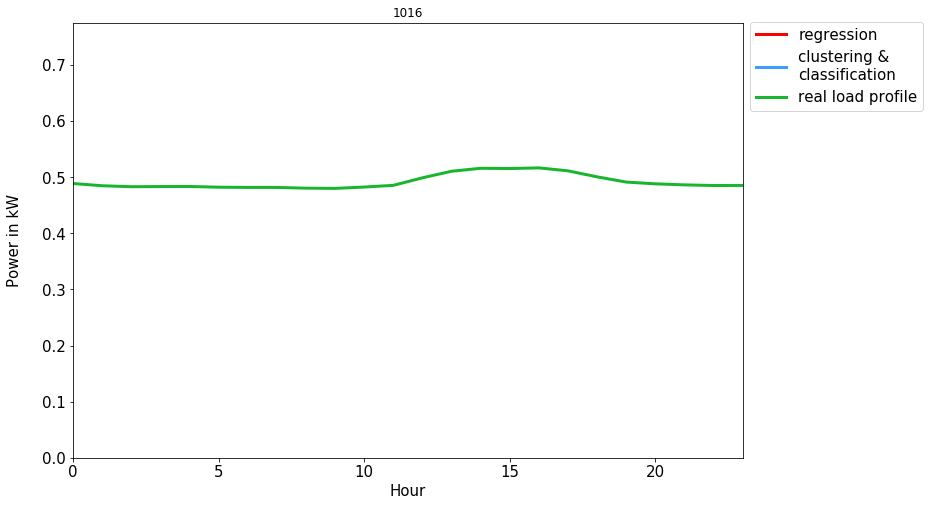

Regression sMAPE: 76.14595814622504
Classification sMAPE: 95.2605865937507
Regression MAPE: 126.36555350710299
Classification MAPE: 182.0770510288162
___________________________________________________


<Figure size 432x288 with 0 Axes>

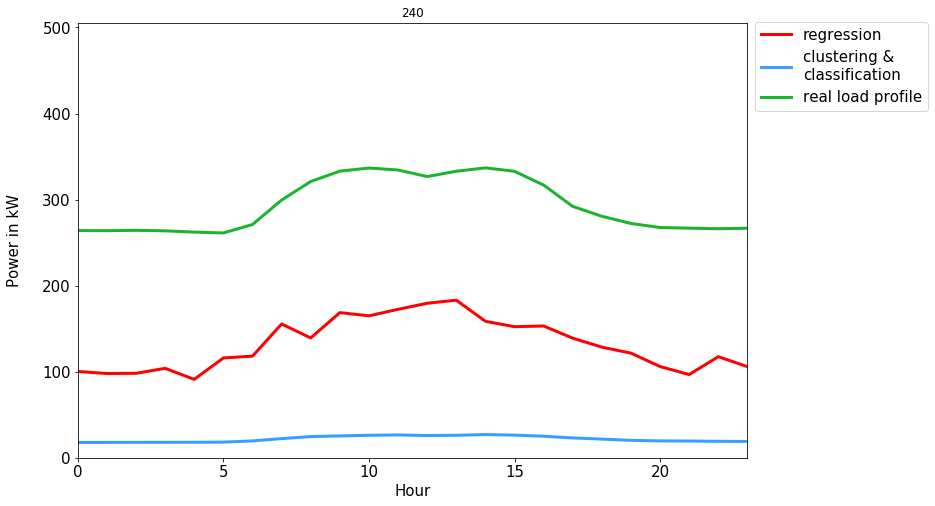

Regression sMAPE: 77.1111356773667
Classification sMAPE: 172.33378688984894
Regression MAPE: 55.42171083555575
Classification MAPE: 92.56780067684062
___________________________________________________


<Figure size 432x288 with 0 Axes>

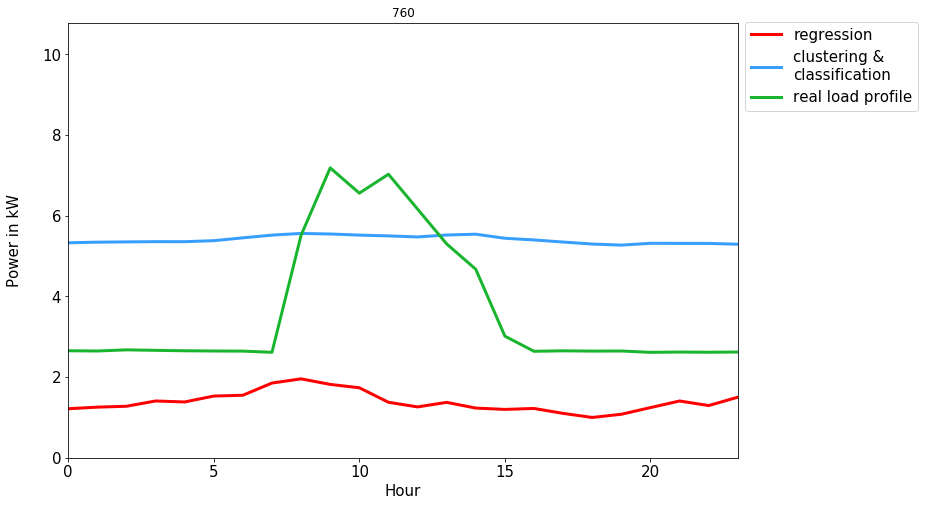

Regression sMAPE: 82.57258560832325
Classification sMAPE: 51.83580585265278
Regression MAPE: 57.19743786294913
Classification MAPE: 75.78964535280932
___________________________________________________


<Figure size 432x288 with 0 Axes>

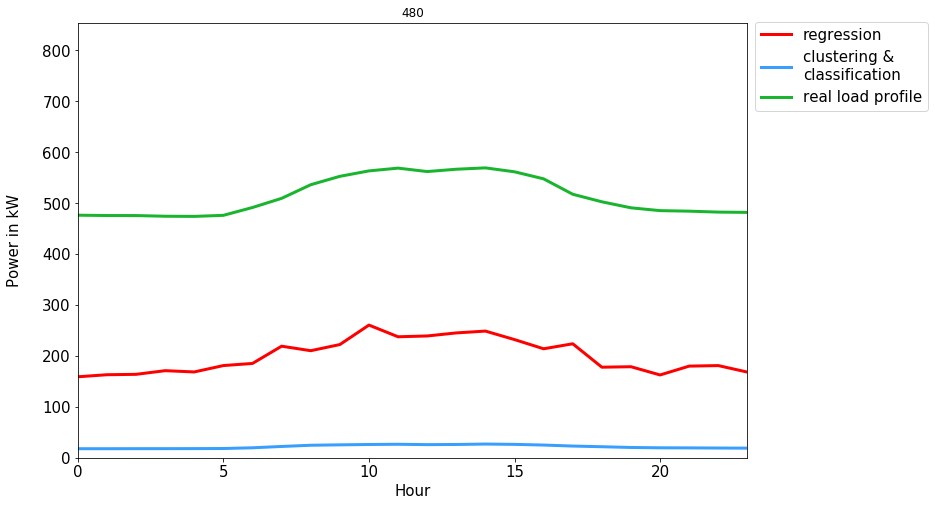

Regression sMAPE: 88.64155348585825
Classification sMAPE: 183.746163736769
Regression MAPE: 61.32392813588672
Classification MAPE: 95.76319453864521
___________________________________________________


<Figure size 432x288 with 0 Axes>

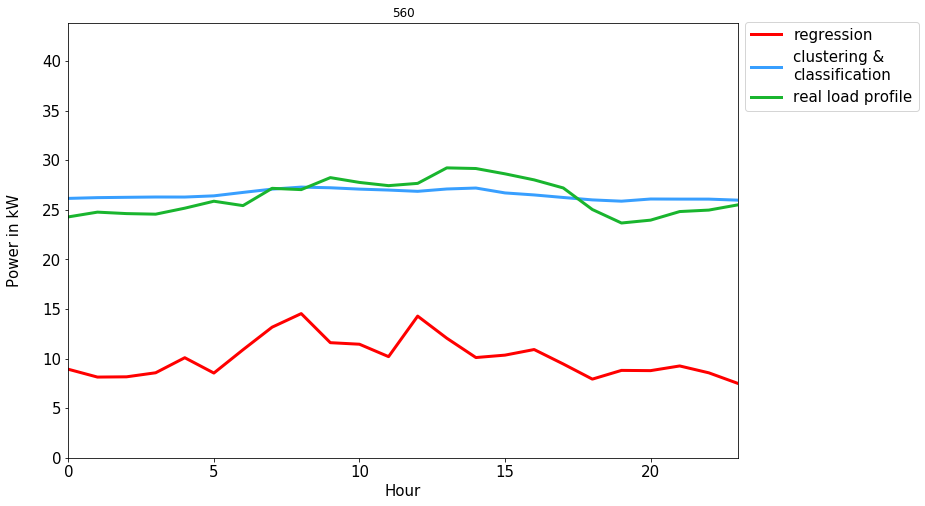

Regression sMAPE: 89.71584549792385
Classification sMAPE: 4.701384100191391
Regression MAPE: 61.69085554098911
Classification MAPE: 4.749548874988191
___________________________________________________


<Figure size 432x288 with 0 Axes>

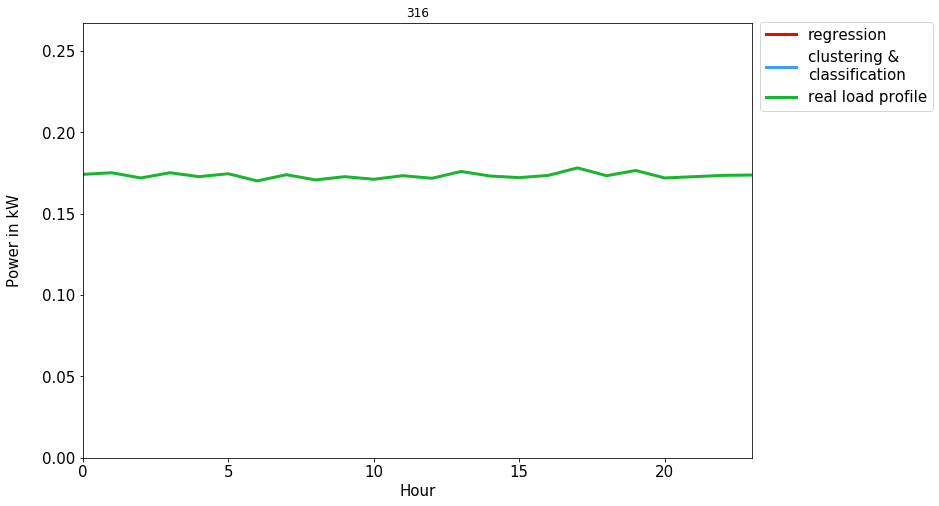

Regression sMAPE: 160.70971080597573
Classification sMAPE: 197.3997757296006
Regression MAPE: 849.915095815655
Classification MAPE: 15191.40862700814
___________________________________________________


<Figure size 432x288 with 0 Axes>

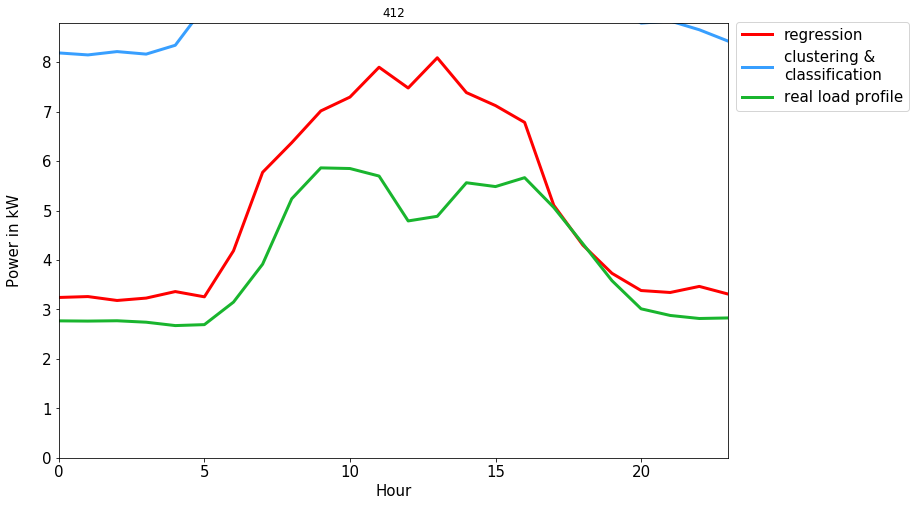

Regression sMAPE: 20.675717512274595
Classification sMAPE: 110.10714189775521
Regression MAPE: 24.062898634132864
Classification MAPE: 260.42758547282125
___________________________________________________


<Figure size 432x288 with 0 Axes>

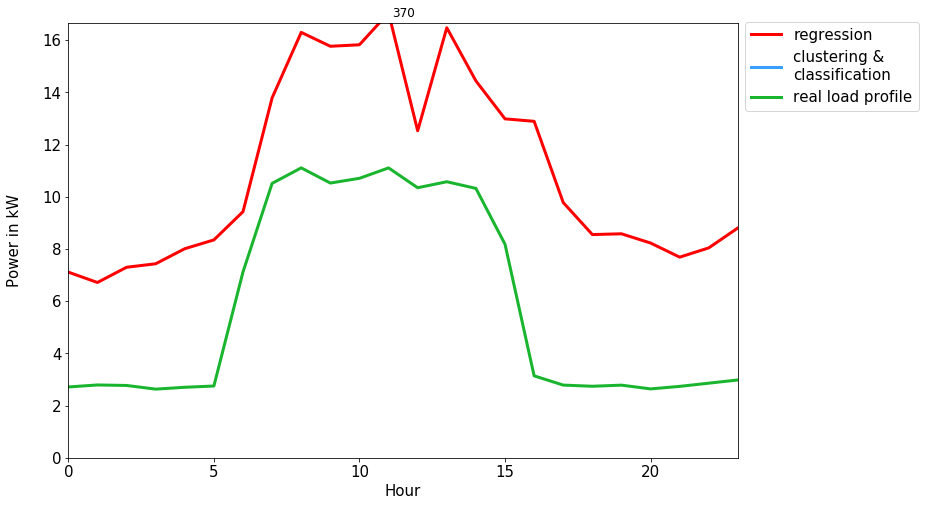

Regression sMAPE: 72.57792551581387
Classification sMAPE: 123.16184727286566
Regression MAPE: 134.86770833041462
Classification MAPE: 416.1991660398592
___________________________________________________


<Figure size 432x288 with 0 Axes>

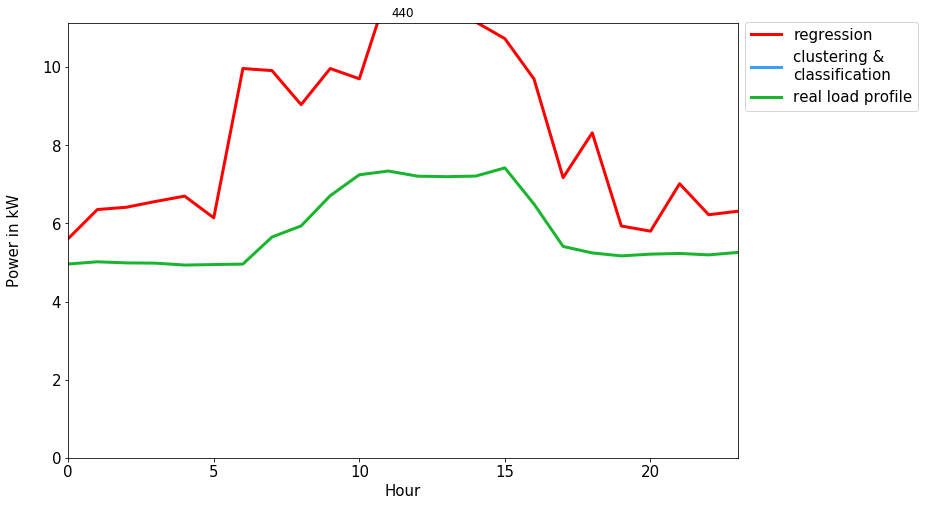

Regression sMAPE: 33.29152724810939
Classification sMAPE: 115.85414212970943
Regression MAPE: 41.79748653540046
Classification MAPE: 276.16828389870847
___________________________________________________


<Figure size 432x288 with 0 Axes>

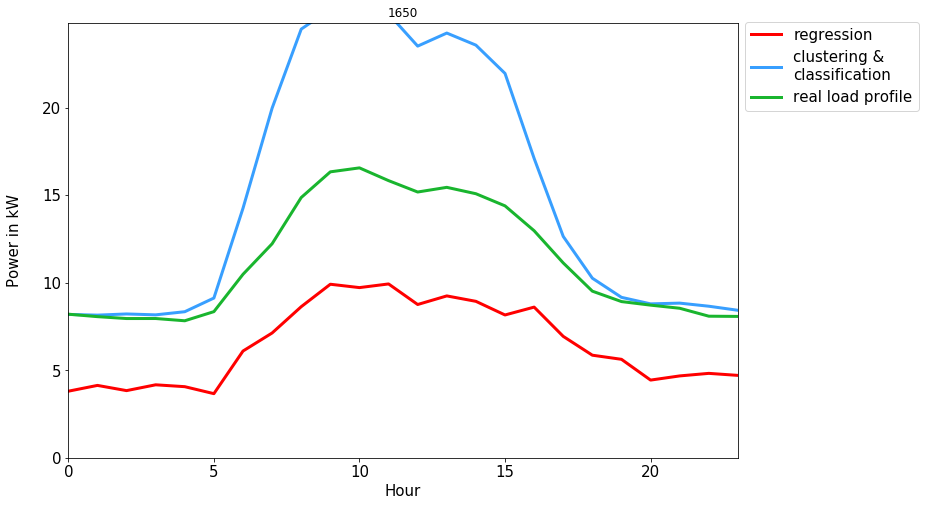

Regression sMAPE: 55.56702490524231
Classification sMAPE: 21.8033119236376
Regression MAPE: 43.28613691924807
Classification MAPE: 27.22379121865353
___________________________________________________


<Figure size 432x288 with 0 Axes>

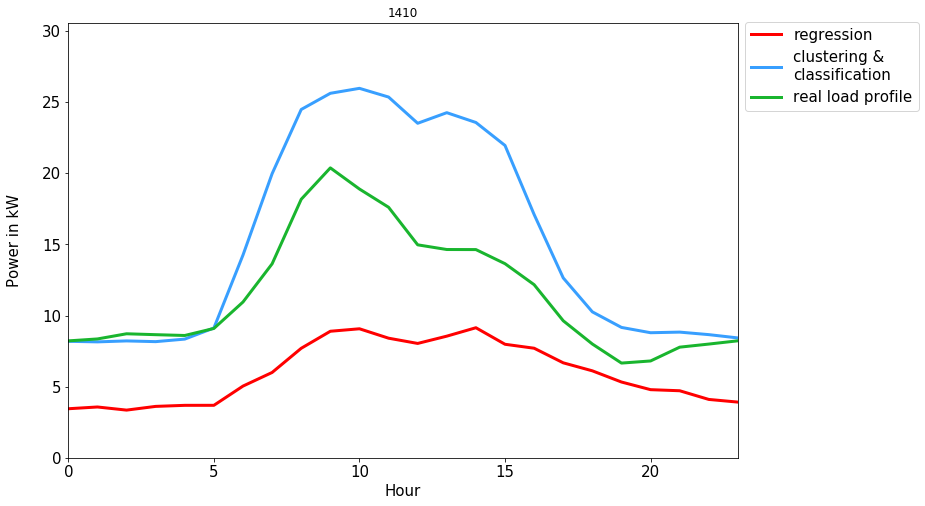

Regression sMAPE: 62.93125991305194
Classification sMAPE: 23.121520785126407
Regression MAPE: 46.99304513337029
Classification MAPE: 27.999683547944983
___________________________________________________


<Figure size 432x288 with 0 Axes>

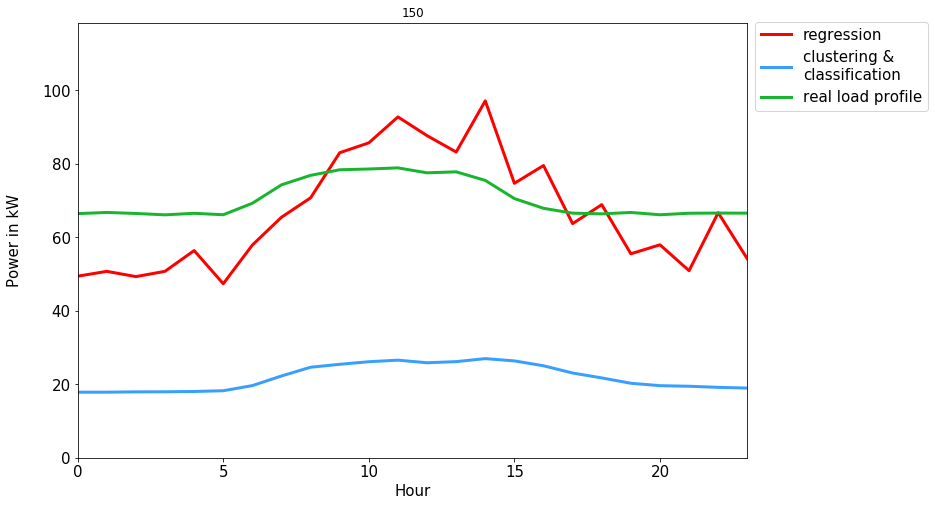

Regression sMAPE: 16.002224720707655
Classification sMAPE: 105.59982978216989
Regression MAPE: 15.097199054596757
Classification MAPE: 69.02813145049826
___________________________________________________


<Figure size 432x288 with 0 Axes>

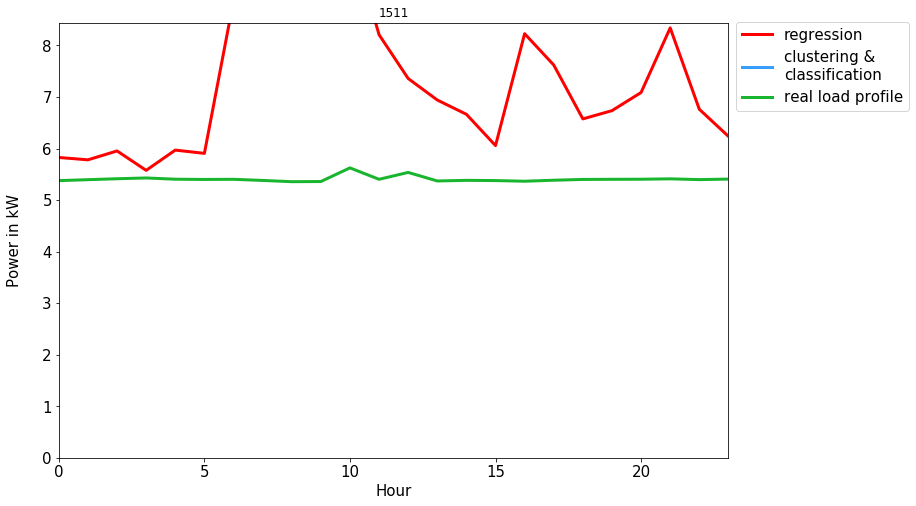

Regression sMAPE: 28.796655343274818
Classification sMAPE: 132.2357940276411
Regression MAPE: 36.746400718093895
Classification MAPE: 390.4316885408823
___________________________________________________


<Figure size 432x288 with 0 Axes>

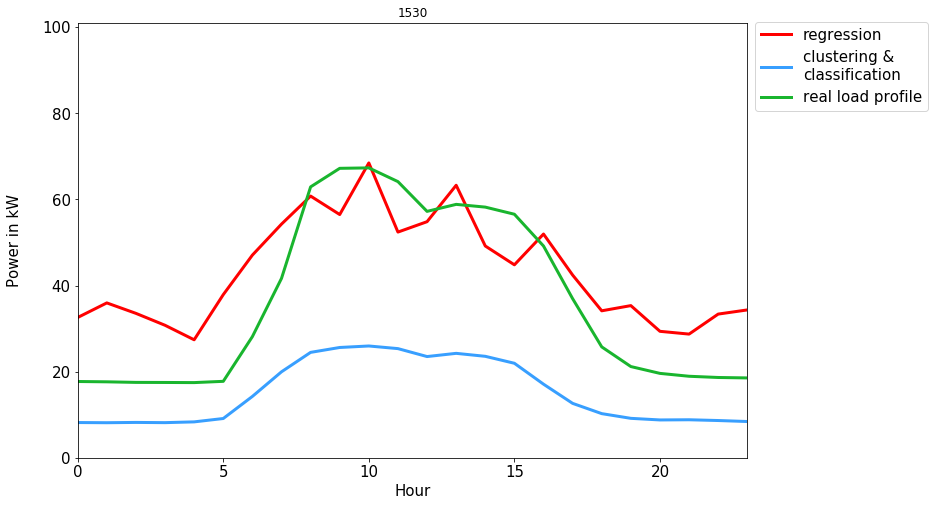

Regression sMAPE: 34.47469871215439
Classification sMAPE: 79.70763463617891
Regression MAPE: 45.66096623937835
Classification MAPE: 56.842165710331884
___________________________________________________


<Figure size 432x288 with 0 Axes>

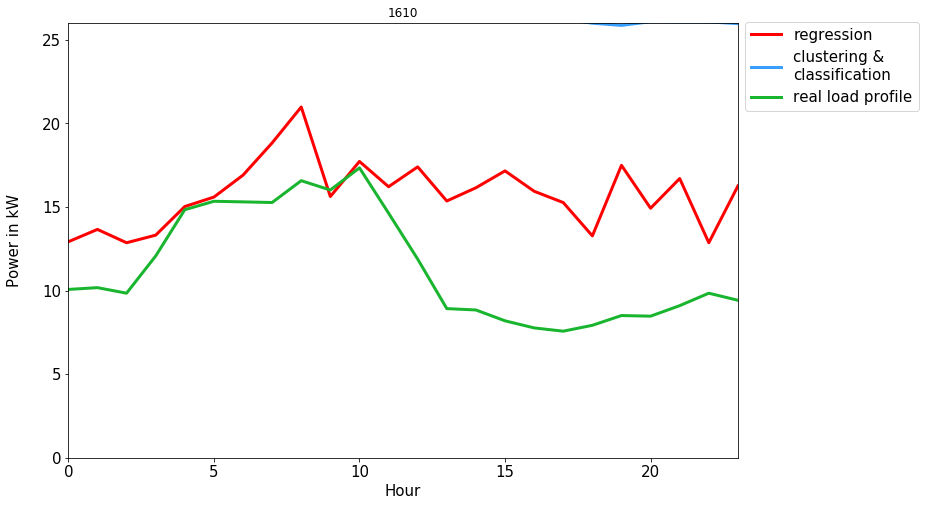

Regression sMAPE: 34.677052288815034
Classification sMAPE: 81.67722965729233
Regression MAPE: 47.324700074860424
Classification MAPE: 149.80208889538827
___________________________________________________


<Figure size 432x288 with 0 Axes>

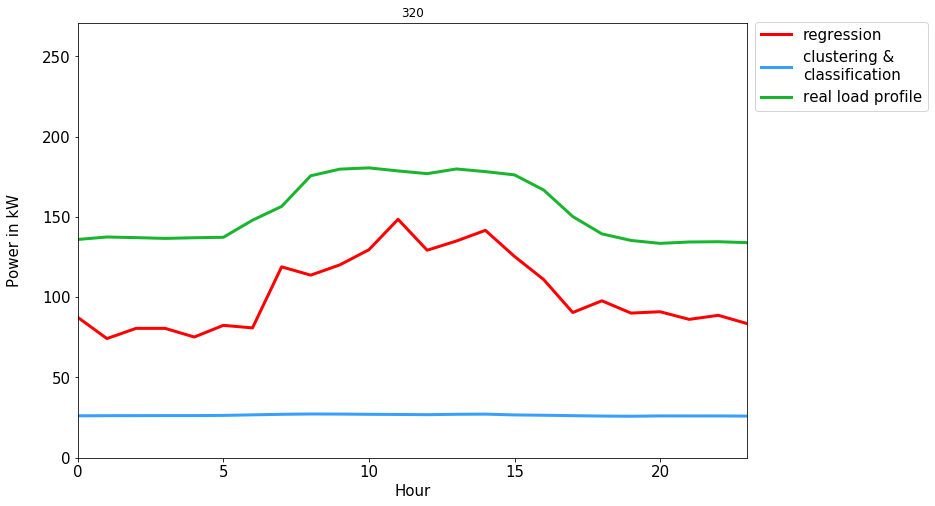

Regression sMAPE: 41.037469366466
Classification sMAPE: 140.42362579275996
Regression MAPE: 33.70994806144065
Classification MAPE: 82.47013678799577
___________________________________________________


<Figure size 432x288 with 0 Axes>

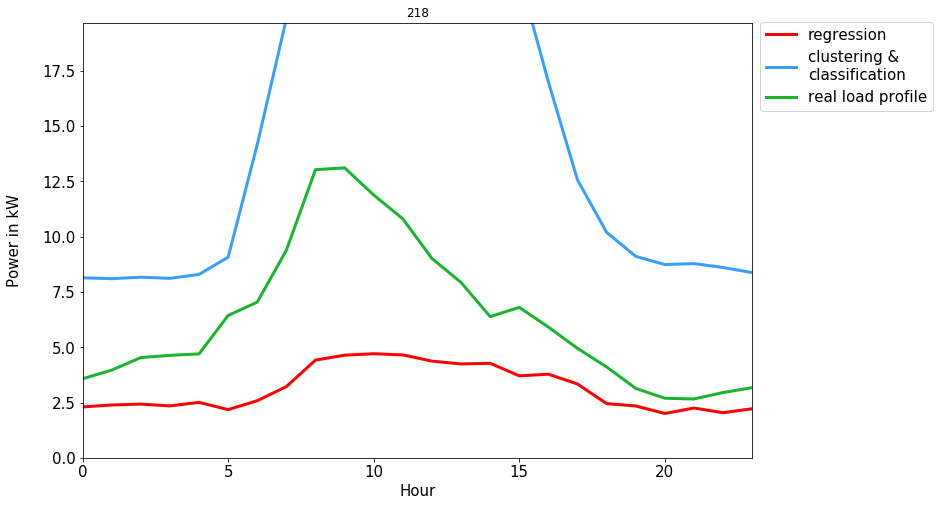

Regression sMAPE: 59.93356679520958
Classification sMAPE: 80.87858183455467
Regression MAPE: 44.74623911625486
Classification MAPE: 145.43633563320586
___________________________________________________


<Figure size 432x288 with 0 Axes>

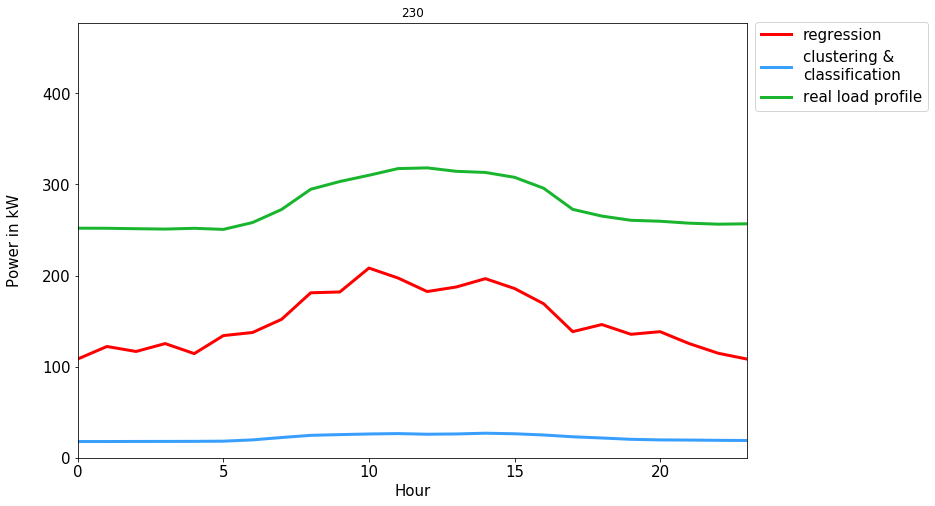

Regression sMAPE: 60.60882101548839
Classification sMAPE: 170.83643304219714
Regression MAPE: 46.22194058727238
Classification MAPE: 92.13300306192558
___________________________________________________


<Figure size 432x288 with 0 Axes>

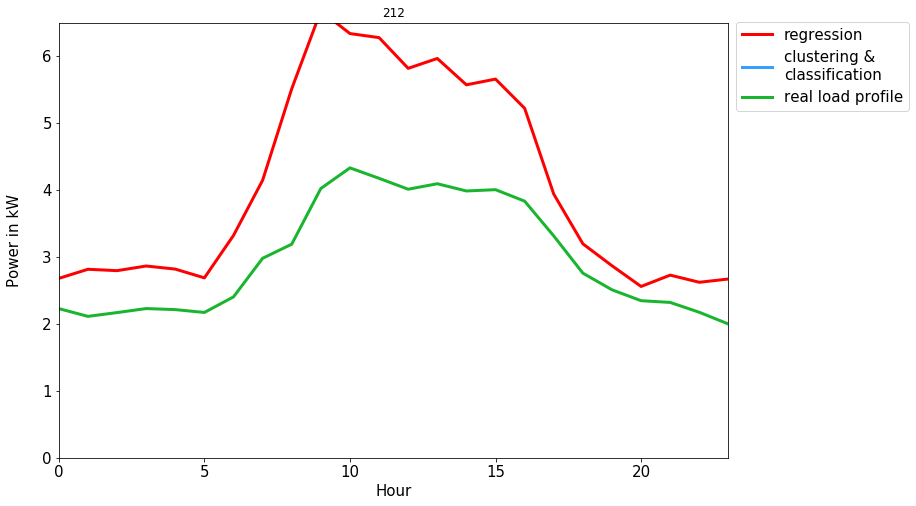

Regression sMAPE: 28.23359004925034
Classification sMAPE: 128.78528330750936
Regression MAPE: 33.86109735370845
Classification MAPE: 384.42515359253224
___________________________________________________


<Figure size 432x288 with 0 Axes>

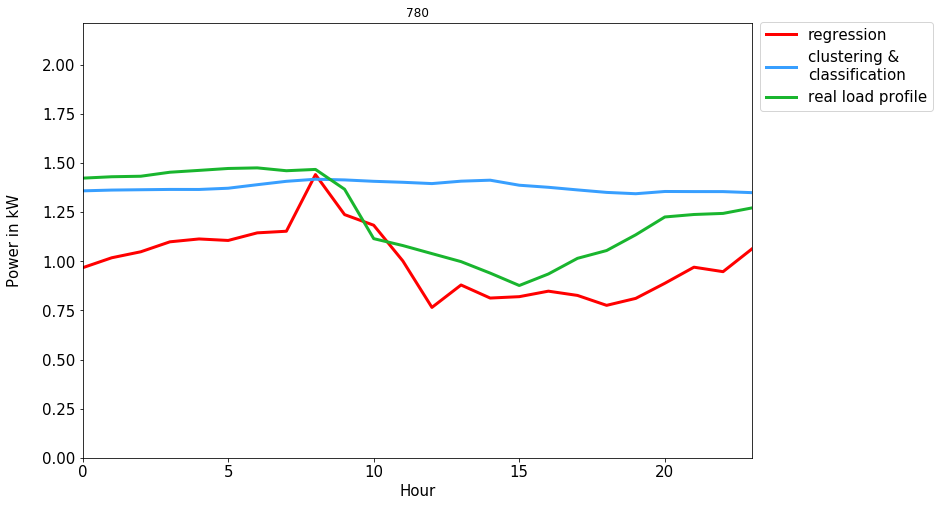

Regression sMAPE: 21.64027284150308
Classification sMAPE: 16.301596691682704
Regression MAPE: 19.142456121663418
Classification MAPE: 18.86080784985857
___________________________________________________


<Figure size 432x288 with 0 Axes>

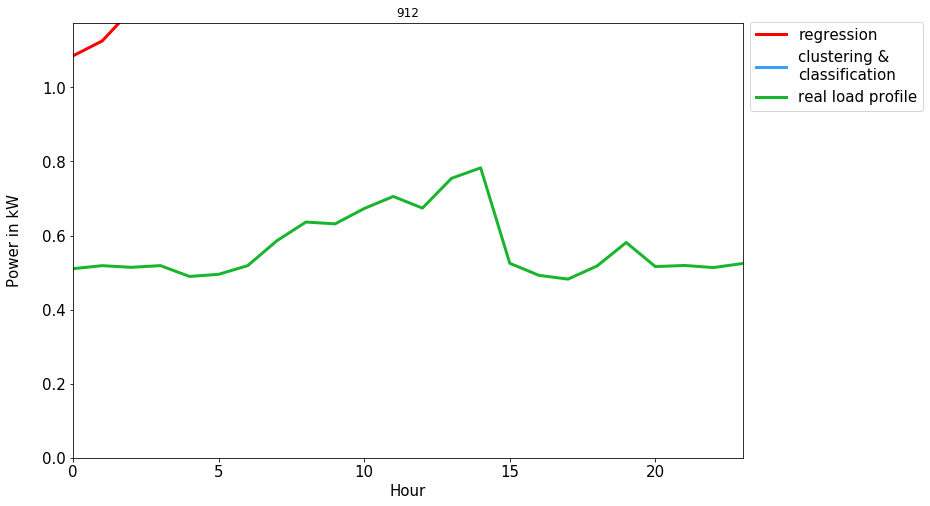

Regression sMAPE: 84.64049287618562
Classification sMAPE: 191.59956723711664
Regression MAPE: 152.1617405434446
Classification MAPE: 4640.500440333371
___________________________________________________



Total Regression sMAPE: 60.766355317619876
Total Classification sMAPE: 108.37595606603739

Total Regression MAPE: 88.96044832493422
Total Classification MAPE: 858.4342345765873


<Figure size 432x288 with 0 Axes>

In [85]:
# FINAL RESULTS
class_sMAPE = 0
reg_sMAPE = 0
class_MAPE = 0
reg_MAPE = 0

for i in range(0,len(y_test)):

    plt.figure(figsize = (12,8))
    plt.title(y_test.index[i])
    (test_regression.transpose()[i]).plot(c = 'r', lw = 3)
    (test_classification.transpose()[i]).plot(c = '#389fff', lw = 3)
    y_test.transpose().iloc[:,i].plot(legend = True, lw = 3, c = '#19b52e', ylim = (0,y_test.transpose().iloc[:,i].max()*1.5))
    plt.legend(['regression','clustering &\nclassification','real load profile'],loc='center left', fontsize = 15, bbox_to_anchor=(1.0, 0.9))
    plt.xlabel('Hour', fontsize = 15)
    plt.ylabel('Power in kW', labelpad=20, fontsize = 15)
    plt.show()
    plt.clf()
    smr = symmetric_mean_absolute_percentage_error(y_test.transpose().iloc[:,i],test_regression.transpose()[i])
    smc = symmetric_mean_absolute_percentage_error(y_test.transpose().iloc[:,i],test_classification.transpose()[i])
    mr = mean_absolute_percentage_error(y_test.transpose().iloc[:,i],test_regression.transpose()[i])
    mc = mean_absolute_percentage_error(y_test.transpose().iloc[:,i],test_classification.transpose()[i])
    print('Regression sMAPE:', smr)
    print('Classification sMAPE:', smc)
    print('Regression MAPE:', mr)
    print('Classification MAPE:', mc)
    print('___________________________________________________')
    reg_sMAPE = reg_sMAPE + smr /(len(y_test)-1)
    class_sMAPE = class_sMAPE + smc/(len(y_test)-1)
    reg_MAPE = reg_MAPE + mr/(len(y_test)-1)
    class_MAPE = class_MAPE + mc/(len(y_test)-1)

print('\n\n\nTotal Regression sMAPE:', reg_sMAPE)
print('Total Classification sMAPE:', class_sMAPE)
print('\nTotal Regression MAPE:', reg_MAPE)
print('Total Classification MAPE:', class_MAPE)